# Leadangle_fitplot3.ipynb

`Leadangle_fit.py`で計算した結果をプロットする。

In [59]:
import numpy as np
import math
import copy
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ptick
from matplotlib.ticker import AutoMinorLocator
from matplotlib.colors import LinearSegmentedColormap  # colormapをカスタマイズする
import matplotlib.colors as colors
import matplotlib.patches as patches
import matplotlib.patheffects as pe
import B_JRM33 as BJRM
import B_equator as BEQ
import Leadangle_wave as LeadA
from TScmap import TScmap

# Color universal design
cud4 = ['#FF3300', '#FFF100', '#03AF7A', '#005AFF', '#4DC4FF', '#FF8082', '#F6AA00', '#990099', '#804000']
cud4bs = ['#FFCABF', '#FFFF80', '#D8F255', '#BFE4FF', '#FFCA80', '#77D9A8', '#C9ACE6', '#84919E']

# matplotlib フォント設定
fontname = 'Nimbus Sans'
plt.rcParams.update({'font.sans-serif': fontname,
                     'font.family': 'sans-serif',
                     'mathtext.fontset': 'custom',
                     'mathtext.rm': fontname,
                     'mathtext.it': fontname+':italic',
                     # 'mathtext.bf': 'Nimbus Sans:italic:bold',
                     'mathtext.bf': fontname+':bold'
                     })
params = {
    # 'lines.markersize': 1,
    # 'lines.linewidth': 1,
    'axes.linewidth': 2,
    'xtick.major.size': 5,
    'xtick.minor.size': 3.5,
    'xtick.major.width': 2.0,
    'xtick.minor.width': 1.25,
    'ytick.major.size': 5,
    'ytick.minor.size': 3,
    'ytick.major.width': 2.0,
    'ytick.minor.width': 1.25,
}
plt.rcParams.update(params)

In [60]:
def generate_cmap(colors):
    """自分で定義したカラーマップを返す"""
    values = range(len(colors))

    vmax = np.ceil(np.max(values))
    color_list = []
    for v, c in zip(values, colors):
        color_list.append((v / vmax, c))
    return LinearSegmentedColormap.from_list('custom_cmap', color_list)

whiteblue=generate_cmap(['#000000','#010E5E','#042AA6','#0F7CE0','#1AC7FF','#FFFFFF'])

In [61]:
# Set legend shadow
def legend_shadow(fig, ax, legend, dx, dy):

  frame = legend.get_window_extent()

  xmin, ymin = fig.transFigure.inverted().transform((frame.xmin, frame.ymin))
  xmax, ymax = fig.transFigure.inverted().transform((frame.xmax, frame.ymax))

  # plot patch shadow
  rect = patches.Rectangle((xmin+dx, ymin+dy), xmax-xmin, ymax-ymin, 
                          transform=fig.transFigure,
                          edgecolor='k', facecolor='k',
                          clip_on=False)
  ax.add_patch(rect)

  return None

In [62]:
# 定数
MOON = 'Europa'
MU0 = 1.26E-6            # 真空中の透磁率
AMU = 1.66E-27           # [kg]
RJ = 71492E+3            # JUPITER RADIUS [m]
C = 2.99792E+8           # 光速 [m/s]
OMGJ = 1.75868E-4        # 木星の自転角速度 [rad/s]
satovalN = np.recfromtxt('data/JRM33/satellite_foot_N.txt', skip_header=3,
                         names=['wlon', 'amlat', 'amwlon', 'iolat', 'iowlon', 'eulat', 'euwlon', 'galat', 'gawlon'])
satovalS = np.recfromtxt('data/JRM33/satellite_foot_S.txt', skip_header=3,
                         names=['wlon', 'amlat', 'amwlon', 'iolat', 'iowlon', 'eulat', 'euwlon', 'galat', 'gawlon'])

In [63]:
# 定数
r_orbitM = 9.38*RJ   # ORBITAL RADIUS (average) [m] (Bagenal+2015)
r_orbitC = 9.30*RJ   # ORBITAL RADIUS (closest) [m] (Bagenal+2015)
r_orbitF = 9.47*RJ   # ORBITAL RADIUS (farthest) [m] (Bagenal+2015)
MOONRADI = 1.56E+6   # MOON RADIUS [m]
OMG_E = 2.0478E-5    # 衛星の公転角速度 [rad/s]
n0 = 110             # [cm-3] (Cassidy+2013)

ne_1 = 63            # 電子数密度 [cm-3] (Bagenal+2015)
ne_2 = 158           # 電子数密度 [cm-3] (Bagenal+2015)
ne_3 = 290           # 電子数密度 [cm-3] (Bagenal+2015)

Ai = 18              # 平均イオン原子量 (Bagenal+2015)
Zi = 1.4             # 平均イオン価数 [q] (Bagenal+2015)

Ti_14 = 68           # 平均イオン温度 [eV] (Best fit 2014_6)
rho0_14 = 1862       # プラズマ質量密度 [amu cm-3] (Best fit 2014_6)

Ti_22 = 138          # 平均イオン温度 [eV] (Best fit 2022_6)
rho0_22 = 2684       # プラズマ質量密度 [amu cm-3] (Best fit 2022_6)

Ti_14 = 74           # 平均イオン温度 [eV] (Best fit 2014_7)
rho0_14 = 1686       # プラズマ質量密度 [amu cm-3] (Best fit 2014_7)

Ti_22 = 134          # 平均イオン温度 [eV] (Best fit 2022_7)
rho0_22 = 2801       # プラズマ質量密度 [amu cm-3] (Best fit 2022_7)

Ti_PJ26 = 53         # 平均イオン温度 [eV] (Best fit PJ26)
rho0_PJ26 = 2868     # プラズマ質量密度 [amu cm-3] (Best fit PJ26)

H_p = 1.8*RJ         # [m]
Hp0 = 0.64*RJ        # 基準スケールハイト [m] (Bagenal&Delamere2011)
wlonN = copy.copy(satovalN.wlon)
FwlonN = copy.copy(satovalN.euwlon)
FlatN = copy.copy(satovalN.eulat)
FwlonS = copy.copy(satovalS.euwlon)
FlatS = copy.copy(satovalS.eulat)

OMGR = OMGJ-OMG_E

In [64]:
# Plasma sheet scale height
Hp_14 = Hp0*math.sqrt(Ti_14/Ai)       # Scale height [m] (Bagenal&Delamere2011)
Hp_22 = Hp0*math.sqrt(Ti_22/Ai)       # Scale height [m] (Bagenal&Delamere2011)
Hp_PJ26 = Hp0*math.sqrt(Ti_PJ26/Ai)   # Scale height [m] (Bagenal&Delamere2011)

In [65]:
# 衛星公転軌道の磁場強度
S3wlon = np.radians(np.linspace(0, 360, 50))      # [rad]
S3lat = np.zeros(S3wlon.shape)                    # [rad]

theta = 0.5*np.pi-S3lat
phi = 2*np.pi-S3wlon
B = np.zeros(phi.shape)
# Br = np.zeros(phi.shape)
# Btheta = np.zeros(phi.shape)
B_far = np.zeros(phi.shape)
B_close = np.zeros(phi.shape)
for i in range(phi.size):
    x = r_orbitM*math.sin(theta[i])*math.cos(phi[i])
    y = r_orbitM*math.sin(theta[i])*math.sin(phi[i])
    z = r_orbitM*math.cos(theta[i])
    Bv = BJRM.B().JRM33(r_orbitM, theta[i], phi[i])*1E-9      # [T]
    Bx = Bv[0]*math.sin(theta[i])*math.cos(phi[i]) \
        + Bv[1]*math.cos(theta[i])*math.cos(phi[i]) \
        - Bv[2]*math.sin(phi[i])
    By = Bv[0]*math.sin(theta[i])*math.sin(phi[i]) \
        + Bv[1]*math.cos(theta[i])*math.sin(phi[i]) \
        + Bv[2]*math.cos(phi[i])
    Bz = Bv[0]*math.cos(theta[i]) - Bv[1]*math.sin(theta[i])
    Bcs = BJRM.B().BCS(x, y, z, phi[i])  # [nT]
    Bx += Bcs[0]*1E-9       # [T]
    By += Bcs[1]*1E-9       # [T]
    Bz += Bcs[2]*1E-9       # [T]
    B[i] = math.sqrt(Bx**2+By**2+Bz**2)      # [T]

    x = r_orbitC*math.sin(theta[i])*math.cos(phi[i])
    y = r_orbitC*math.sin(theta[i])*math.sin(phi[i])
    z = r_orbitC*math.cos(theta[i])
    Bv = BJRM.B().JRM33(r_orbitC, theta[i], phi[i])*1E-9      # [T]
    Bx = Bv[0]*math.sin(theta[i])*math.cos(phi[i]) \
        + Bv[1]*math.cos(theta[i])*math.cos(phi[i]) \
        - Bv[2]*math.sin(phi[i])
    By = Bv[0]*math.sin(theta[i])*math.sin(phi[i]) \
        + Bv[1]*math.cos(theta[i])*math.sin(phi[i]) \
        + Bv[2]*math.cos(phi[i])
    Bz = Bv[0]*math.cos(theta[i]) - Bv[1]*math.sin(theta[i])
    Bcs = BJRM.B().BCS(x, y, z, phi[i])  # [nT]
    Bx += Bcs[0]*1E-9       # [T]
    By += Bcs[1]*1E-9       # [T]
    Bz += Bcs[2]*1E-9       # [T]
    B_close[i] = math.sqrt(Bx**2+By**2+Bz**2)      # [T]

    x = r_orbitF*math.sin(theta[i])*math.cos(phi[i])
    y = r_orbitF*math.sin(theta[i])*math.sin(phi[i])
    z = r_orbitF*math.cos(theta[i])
    Bv = BJRM.B().JRM33(r_orbitF, theta[i], phi[i])*1E-9      # [T]
    Bx = Bv[0]*math.sin(theta[i])*math.cos(phi[i]) \
        + Bv[1]*math.cos(theta[i])*math.cos(phi[i]) \
        - Bv[2]*math.sin(phi[i])
    By = Bv[0]*math.sin(theta[i])*math.sin(phi[i]) \
        + Bv[1]*math.cos(theta[i])*math.sin(phi[i]) \
        + Bv[2]*math.cos(phi[i])
    Bz = Bv[0]*math.cos(theta[i]) - Bv[1]*math.sin(theta[i])
    Bcs = BJRM.B().BCS(x, y, z, phi[i])  # [nT]
    Bx += Bcs[0]*1E-9       # [T]
    By += Bcs[1]*1E-9       # [T]
    Bz += Bcs[2]*1E-9       # [T]
    B_far[i] = math.sqrt(Bx**2+By**2+Bz**2)      # [T]

In [66]:
# 衛星のトーラス内相対位置
# S3RH座標系の(x, y, z)座標
x0 = r_orbitM*np.cos(phi)
y0 = r_orbitM*np.sin(phi)
z0 = np.zeros(x0.shape)
rvec0 = np.array([x0, y0, z0])

# S3RH で Z軸 の(右ネジ)まわりに-65.8度回転
phiRH0 = math.radians(-65.8)    # Connerney+2020
rvec0 = np.array([
    rvec0[0, :]*math.cos(phiRH0) - rvec0[1, :]*math.sin(phiRH0),
    rvec0[0, :]*math.sin(phiRH0) + rvec0[1, :]*math.cos(phiRH0),
    rvec0[2, :]
])

# S3RH で X軸 の(右ネジ)まわりに-7度回転 -> 遠心力座標系に
TILT0 = math.radians(6.7)
rvec = np.array([
    rvec0[0, :],
    rvec0[1, :]*math.cos(TILT0) - rvec0[2, :]*math.sin(TILT0),
    rvec0[1, :]*math.sin(TILT0) + rvec0[2, :]*math.cos(TILT0)
])

# 遠心力座標系における緯度を計算する
theta_cent = np.arccos(rvec[2, :]/r_orbitM)     # 余緯度 [rad]
lat_cent = np.degrees(0.5*np.pi-theta_cent)     # 緯度 [deg]

# STIS Jan2014 Oct2022

In [67]:
# HST data
cpalette = ['#E7534B', '#EF8C46', '#F7D702', '#3C8867', '#649CDB', '#5341A5', '#A65FAC', '#A2AAAD']

hem = 'North'

north_doy14 = ['14/006_v06', '14/013_v13', '14/016_v12']
north_doy22 = ['22/271_v18', '22/274_v17']
north_doy = north_doy14 + north_doy22
south_doy = ['22/185_v09', '22/310_v19', '22/349_v23']

nbkg_doy = ['14/001_v01', '14/002_v02', '14/005_v05', '14/006_v06', '14/013_v13', '14/016_v12', '22/185_v10', '22/228_v13', '22/271_v18', '22/274_v17', '22/309_v20', '22/349_v24']
sbkg_doy = ['22/140_v03', '22/185_v09', '22/186_v11', '22/229_v14', '22/310_v19', '22/311_v21', '22/349_v23']

if hem == 'North':
    doy = north_doy
    bkgdoy = nbkg_doy
elif hem == 'South':
    doy = south_doy
    bkgdoy = sbkg_doy
else:
    doy = north_doy+south_doy
    bkgdoy = nbkg_doy+sbkg_doy

refnum = 'N'
if hem == 'South':
    refnum = 'S'
satoval = np.recfromtxt('data/JRM33/satellite_foot_'+refnum+'.txt', skip_header=3,
                names=['wlon', 'amlat', 'amwlon', 'iolat', 'iowlon', 'eulat', 'euwlon', 'galat', 'gawlon'])

# 4枚絵

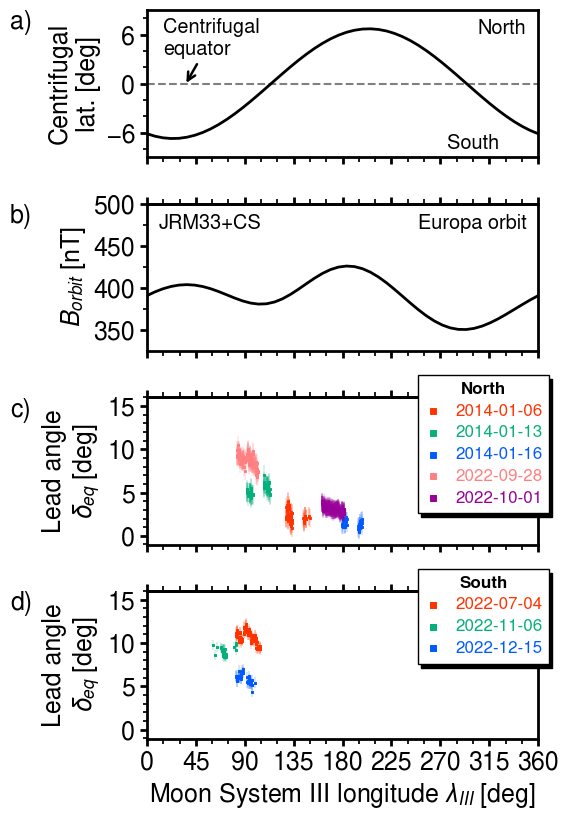

In [68]:
fsize = 18
fig, ax = plt.subplots(4, 1, figsize=(4.7, 7.9), dpi=100,
                       height_ratios=[1, 1, 1, 1])
# plt.subplots_adjust(left=0.2, top=0.95)
fig.tight_layout()
panelname = ['a','b','c','d','e','f','g','h']
for i in range(ax.size):
    ax[i].set_xlim(0, 360)
    ax[i].tick_params(axis='y', labelsize=fsize)
    ax[i].set_xticks(np.arange(0, 361, 45))
    ax[i].set_xticklabels(np.arange(0, 361, 45), fontsize=fsize)
    ax[i].xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
    if i != 0:
        ax2 = ax[i].secondary_xaxis('top')
        ax2.set_xticks(np.arange(0, 361, 45))
        ax2.set_xticklabels(np.arange(0, 361, 45), fontsize=fsize)
        ax2.xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
        plt.setp(ax2.get_xticklabels(), visible=False)  # ラベルを消す
    if i != ax.size-1:
        plt.setp(ax[i].get_xticklabels(), visible=False)  # ラベルを消す
    ax[i].text(-0.35, 1.0, panelname[i]+')', color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[i].transAxes,
           fontsize=fsize)


# ax[0].set_title(MOON+' - Lead Angle Estimation', weight='bold', fontsize=fsize)
ax[0].set_ylim(-9.0, 9.0)
ax[0].set_ylabel('Centrifugal\nlat. [deg]', fontsize=fsize)
ax[0].set_yticks(np.arange(-6, 7, 6))
# ax[0].set_yticklabels(np.arange(-2, 3, 1))
ax[0].yaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
ax[0].plot(np.degrees(S3wlon), lat_cent, linewidth=2, color='k')
ax[0].axhline(y=0, color='gray', linestyle='dashed', zorder=0.5)
ax[0].annotate('Centrifugal\nequator', fontsize=fsize*0.8,
               xy=(35, -0.2), xytext=(15, 3.5), xycoords='data', ha='left',
               arrowprops=dict(arrowstyle='->', connectionstyle='arc3', fc='white', lw=1.8, ec='k', clip_on=True))
ax[0].text(0.97, 0.94,
           'North',
           color='k',
           horizontalalignment='right',
           verticalalignment='top',
           transform=ax[0].transAxes,
           fontsize=fsize*0.8)
ax[0].text(0.90, 0.16,
           'South',
           color='k',
           horizontalalignment='right',
           verticalalignment='top',
           transform=ax[0].transAxes,
           fontsize=fsize*0.8)


ax[1].set_ylim(325, 500)
ax[1].set_ylabel('$B_{orbit}$ [nT]', fontsize=fsize)
ax[1].set_yticks(np.arange(350, 501, 50))
ax[1].set_yticklabels(np.arange(350, 501, 50))
ax[1].plot(np.degrees(S3wlon), B*(1E+9),
           linestyle='solid', linewidth=2, color='k')
ax[1].yaxis.set_minor_locator(AutoMinorLocator(2))  # minor ticks
ax[1].text(0.03, 0.93, 'JRM33+CS', color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[1].transAxes,
           fontsize=fsize*0.8)
ax[1].text(0.97, 0.93, 'Europa orbit', color='k',
           horizontalalignment='right',
           verticalalignment='top',
           transform=ax[1].transAxes,
           fontsize=fsize*0.8)

for i in [2,3]:
    ax[i].set_ylim(-1.05, 16)
    ax[i].set_ylabel('Lead angle\n$\delta_{eq}$ [deg]', fontsize=fsize)
    ax[i].set_yticks(np.arange(0, 16, 5))
    ax[i].set_yticklabels(np.arange(0, 16, 5))
    ax[i].yaxis.set_minor_locator(AutoMinorLocator(5))  # minor ticks

# North - 2014
cud4_14 = [cud4[0], cud4[2], cud4[3]]
doyname = ['2014-01-06', '2014-01-13', '2014-01-16']
la_err = np.array([1.0614052546455, 1.1145213015136, 0.8732066510795])
for i in range(len(north_doy14)):
    data_arr = np.loadtxt('data/red3_leadangle/EUROPA/20'+north_doy14[i]+'_eq.txt')
    moons30_arr = data_arr[0,:]    # moon s3 longitude [deg]
    eq_leadangle = data_arr[1,:]   # lead angle [deg]
    ax[2].scatter(moons30_arr, eq_leadangle, marker=',', s=0.9, c=cud4_14[i],
                  label=str(doyname[i]), linewidths=0.65, zorder=1)
    ax[2].errorbar(moons30_arr, eq_leadangle, yerr=la_err[i]*np.ones(moons30_arr.shape),
                   linestyle='none', ecolor=cud4_14[i], elinewidth=0.22, marker='none', zorder=1)

# North - 2022
cud4_22 = [cud4[5], cud4[7]]
doyname = ['2022-09-28', '2022-10-01']
la_err = np.array([1.0478863038047, 0.8994575700965])
for i in range(len(north_doy22)):
    data_arr = np.loadtxt('data/red3_leadangle/EUROPA/20'+north_doy22[i]+'_eq.txt')
    moons30_arr = data_arr[0,:]   # moon s3 longitude [deg]
    eq_leadangle = data_arr[1,:]   # lead angle [deg]
    ax[2].scatter(moons30_arr, eq_leadangle, marker=',', s=0.9, c=cud4_22[i],
                  label=str(doyname[i]), linewidths=0.7, zorder=1.5)
    ax[2].errorbar(moons30_arr, eq_leadangle, yerr=la_err[i]*np.ones(moons30_arr.shape),
                   linestyle='none', ecolor=cud4_22[i], elinewidth=0.22, marker='none', zorder=1.5)

legend_fsize = fsize*0.68
legend1 = ax[2].legend(loc='upper center',
                       ncol=1,
                       markerscale=5,
                    bbox_to_anchor=(0.86, 1.21),
                    fancybox=False,
                    facecolor='white',
                    framealpha=1,
                    edgecolor='k',
                    fontsize=legend_fsize,
                    labelspacing=0.34,
                    handlelength=1,)
legend1.set_title('North', prop={'size': legend_fsize, 'weight': 'bold'})
legend_shadow(fig, ax[2], legend1, dx=0.007, dy=-0.005)

# get contour colors
i = 0
for leg1text in legend1.get_texts():
    leg1text.set_color((cud4_14+cud4_22)[i])
    i += 1

# South - 2022
cud4_22 = [cud4[0], cud4[2], cud4[3]]
doyname = ['2022-07-04', '2022-11-06', '2022-12-15']
la_err = np.array([0.6379928352107, 0.56611511426765, 0.6325058969635])
for i in range(len(south_doy)):
    data_arr = np.loadtxt('data/red3_leadangle/EUROPA/20'+south_doy[i]+'R_eq.txt')
    moons30_arr = data_arr[0,:]   # moon s3 longitude [deg]
    eq_leadangle = data_arr[1,:]   # lead angle [deg]
    ax[3].scatter(moons30_arr, eq_leadangle, marker=',', s=0.9, c=cud4_22[i],
                  label=str(doyname[i]), linewidths=0.7, zorder=1)
    ax[3].errorbar(moons30_arr, eq_leadangle, yerr=la_err[i]*np.ones(moons30_arr.shape),
                   linestyle='none', ecolor=cud4_22[i], elinewidth=0.22, marker='none', zorder=1.5)
    
legend1 = ax[3].legend(loc='upper center',
                       ncol=1,
                       markerscale=5,
                    bbox_to_anchor=(0.86, 1.21),
                    fancybox=False,
                    facecolor='white',
                    framealpha=1,
                    edgecolor='k',
                    fontsize=legend_fsize,
                    labelspacing=0.34,
                    handlelength=1,)
legend1.set_title('South', prop={'size': legend_fsize, 'weight': 'bold'})
legend_shadow(fig, ax[3], legend1, dx=0.007, dy=-0.005)

ax[3].set_xlabel("Moon System III longitude $\\lambda_{III}$ [deg]", fontsize=fsize)

# get contour colors
i = 0
for leg1text in legend1.get_texts():
    leg1text.set_color(cud4_22[i])
    i += 1

plt.show()

# 3枚絵

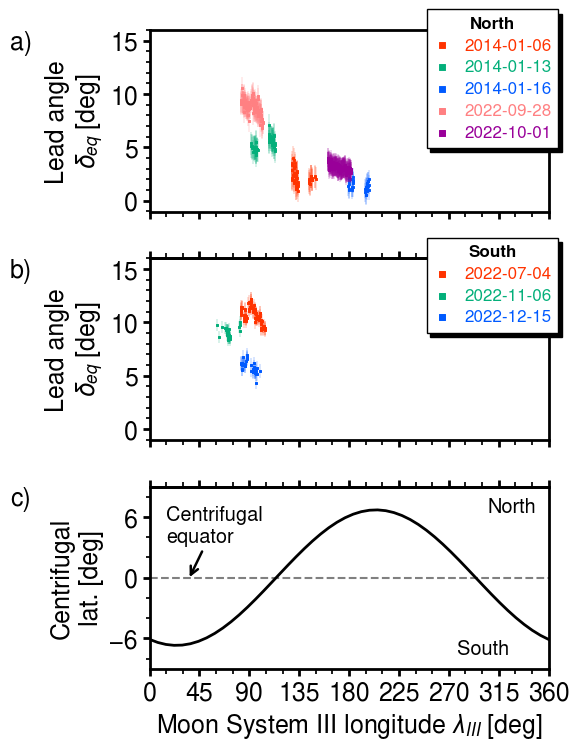

In [69]:
fsize = 18
fig, ax = plt.subplots(3, 1, figsize=(4.7, 7), dpi=100,
                       height_ratios=[1, 1, 1])
# plt.subplots_adjust(left=0.2, top=0.95)
fig.tight_layout()
panelname = ['a','b','c','d','e','f','g','h']
for i in range(ax.size):
    ax[i].set_xlim(0, 360)
    ax[i].tick_params(axis='y', labelsize=fsize)
    ax[i].set_xticks(np.arange(0, 361, 45))
    ax[i].set_xticklabels(np.arange(0, 361, 45), fontsize=fsize)
    ax[i].xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
    if i != 0:
        ax2 = ax[i].secondary_xaxis('top')
        ax2.set_xticks(np.arange(0, 361, 45))
        ax2.set_xticklabels(np.arange(0, 361, 45), fontsize=fsize)
        ax2.xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
        plt.setp(ax2.get_xticklabels(), visible=False)  # ラベルを消す
    if i != ax.size-1:
        plt.setp(ax[i].get_xticklabels(), visible=False)  # ラベルを消す
    ax[i].text(-0.35, 1.0, panelname[i]+')', color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[i].transAxes,
           fontsize=fsize)


for i in [0,1]:
    ax[i].set_ylim(-1.05, 16)
    ax[i].set_ylabel('Lead angle\n$\delta_{eq}$ [deg]', fontsize=fsize)
    ax[i].set_yticks(np.arange(0, 16, 5))
    ax[i].set_yticklabels(np.arange(0, 16, 5))
    ax[i].yaxis.set_minor_locator(AutoMinorLocator(5))  # minor ticks

# North - 2014
cud4_14 = [cud4[0], cud4[2], cud4[3]]
doyname = ['2014-01-06', '2014-01-13', '2014-01-16']
la_err = np.array([1.0614052546455, 1.1145213015136, 0.8732066510795])
for i in range(len(north_doy14)):
    data_arr = np.loadtxt('data/red3_leadangle/EUROPA/20'+north_doy14[i]+'_eq.txt')
    moons30_arr = data_arr[0,:]    # moon s3 longitude [deg]
    eq_leadangle = data_arr[1,:]   # lead angle [deg]
    ax[0].scatter(moons30_arr, eq_leadangle, marker=',', s=0.9, c=cud4_14[i],
                  label=str(doyname[i]), linewidths=0.65, zorder=1)
    ax[0].errorbar(moons30_arr, eq_leadangle, yerr=la_err[i]*np.ones(moons30_arr.shape),
                   linestyle='none', ecolor=cud4_14[i], elinewidth=0.22, marker='none', zorder=1)

# North - 2022
cud4_22 = [cud4[5], cud4[7]]
doyname = ['2022-09-28', '2022-10-01']
la_err = np.array([1.0478863038047, 0.8994575700965])
for i in range(len(north_doy22)):
    data_arr = np.loadtxt('data/red3_leadangle/EUROPA/20'+north_doy22[i]+'_eq.txt')
    moons30_arr = data_arr[0,:]   # moon s3 longitude [deg]
    eq_leadangle = data_arr[1,:]   # lead angle [deg]
    ax[0].scatter(moons30_arr, eq_leadangle, marker=',', s=0.9, c=cud4_22[i],
                  label=str(doyname[i]), linewidths=0.7, zorder=1.5)
    ax[0].errorbar(moons30_arr, eq_leadangle, yerr=la_err[i]*np.ones(moons30_arr.shape),
                   linestyle='none', ecolor=cud4_22[i], elinewidth=0.22, marker='none', zorder=1.5)

legend_fsize = fsize*0.68
legend1 = ax[0].legend(loc='upper center',
                       ncol=1,
                       markerscale=5,
                    bbox_to_anchor=(0.86, 1.16),
                    fancybox=False,
                    facecolor='white',
                    framealpha=1,
                    edgecolor='k',
                    fontsize=legend_fsize,
                    labelspacing=0.34,
                    handlelength=1,)
legend1.set_title('North', prop={'size': legend_fsize, 'weight': 'bold'})
legend_shadow(fig, ax[0], legend1, dx=0.007, dy=-0.006)

# get contour colors
i = 0
for leg1text in legend1.get_texts():
    leg1text.set_color((cud4_14+cud4_22)[i])
    i += 1

# South - 2022
cud4_22 = [cud4[0], cud4[2], cud4[3]]
doyname = ['2022-07-04', '2022-11-06', '2022-12-15']
la_err = np.array([0.6379928352107, 0.56611511426765, 0.6325058969635])
for i in range(len(south_doy)):
    data_arr = np.loadtxt('data/red3_leadangle/EUROPA/20'+south_doy[i]+'R_eq.txt')
    moons30_arr = data_arr[0,:]   # moon s3 longitude [deg]
    eq_leadangle = data_arr[1,:]   # lead angle [deg]
    ax[1].scatter(moons30_arr, eq_leadangle, marker=',', s=0.9, c=cud4_22[i],
                  label=str(doyname[i]), linewidths=0.7, zorder=1)
    ax[1].errorbar(moons30_arr, eq_leadangle, yerr=la_err[i]*np.ones(moons30_arr.shape),
                   linestyle='none', ecolor=cud4_22[i], elinewidth=0.22, marker='none', zorder=1.5)
    
legend1 = ax[1].legend(loc='upper center',
                       ncol=1,
                       markerscale=5,
                    bbox_to_anchor=(0.86, 1.16),
                    fancybox=False,
                    facecolor='white',
                    framealpha=1,
                    edgecolor='k',
                    fontsize=legend_fsize,
                    labelspacing=0.34,
                    handlelength=1,)
legend1.set_title('South', prop={'size': legend_fsize, 'weight': 'bold'})
legend_shadow(fig, ax[1], legend1, dx=0.007, dy=-0.006)


# ax[2].set_title(MOON+' - Lead Angle Estimation', weight='bold', fontsize=fsize)
ax[2].set_ylim(-9.0, 9.0)
ax[2].set_ylabel('Centrifugal\nlat. [deg]', fontsize=fsize)
ax[2].set_yticks(np.arange(-6, 7, 6))
# ax[2].set_yticklabels(np.arange(-2, 3, 1))
ax[2].yaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
ax[2].plot(np.degrees(S3wlon), lat_cent, linewidth=2, color='k')
ax[2].axhline(y=0, color='gray', linestyle='dashed', zorder=0.5)
ax[2].annotate('Centrifugal\nequator', fontsize=fsize*0.8,
               xy=(35, -0.2), xytext=(15, 3.5), xycoords='data', ha='left',
               arrowprops=dict(arrowstyle='->', connectionstyle='arc3', fc='white', lw=1.8, ec='k', clip_on=True))
ax[2].text(0.97, 0.94,
           'North',
           color='k',
           horizontalalignment='right',
           verticalalignment='top',
           transform=ax[2].transAxes,
           fontsize=fsize*0.8)
ax[2].text(0.90, 0.16,
           'South',
           color='k',
           horizontalalignment='right',
           verticalalignment='top',
           transform=ax[2].transAxes,
           fontsize=fsize*0.8)


ax[2].set_xlabel("Moon System III longitude $\\lambda_{III}$ [deg]", fontsize=fsize)

# get contour colors
i = 0
for leg1text in legend1.get_texts():
    leg1text.set_color(cud4_22[i])
    i += 1

plt.show()

# 2枚絵

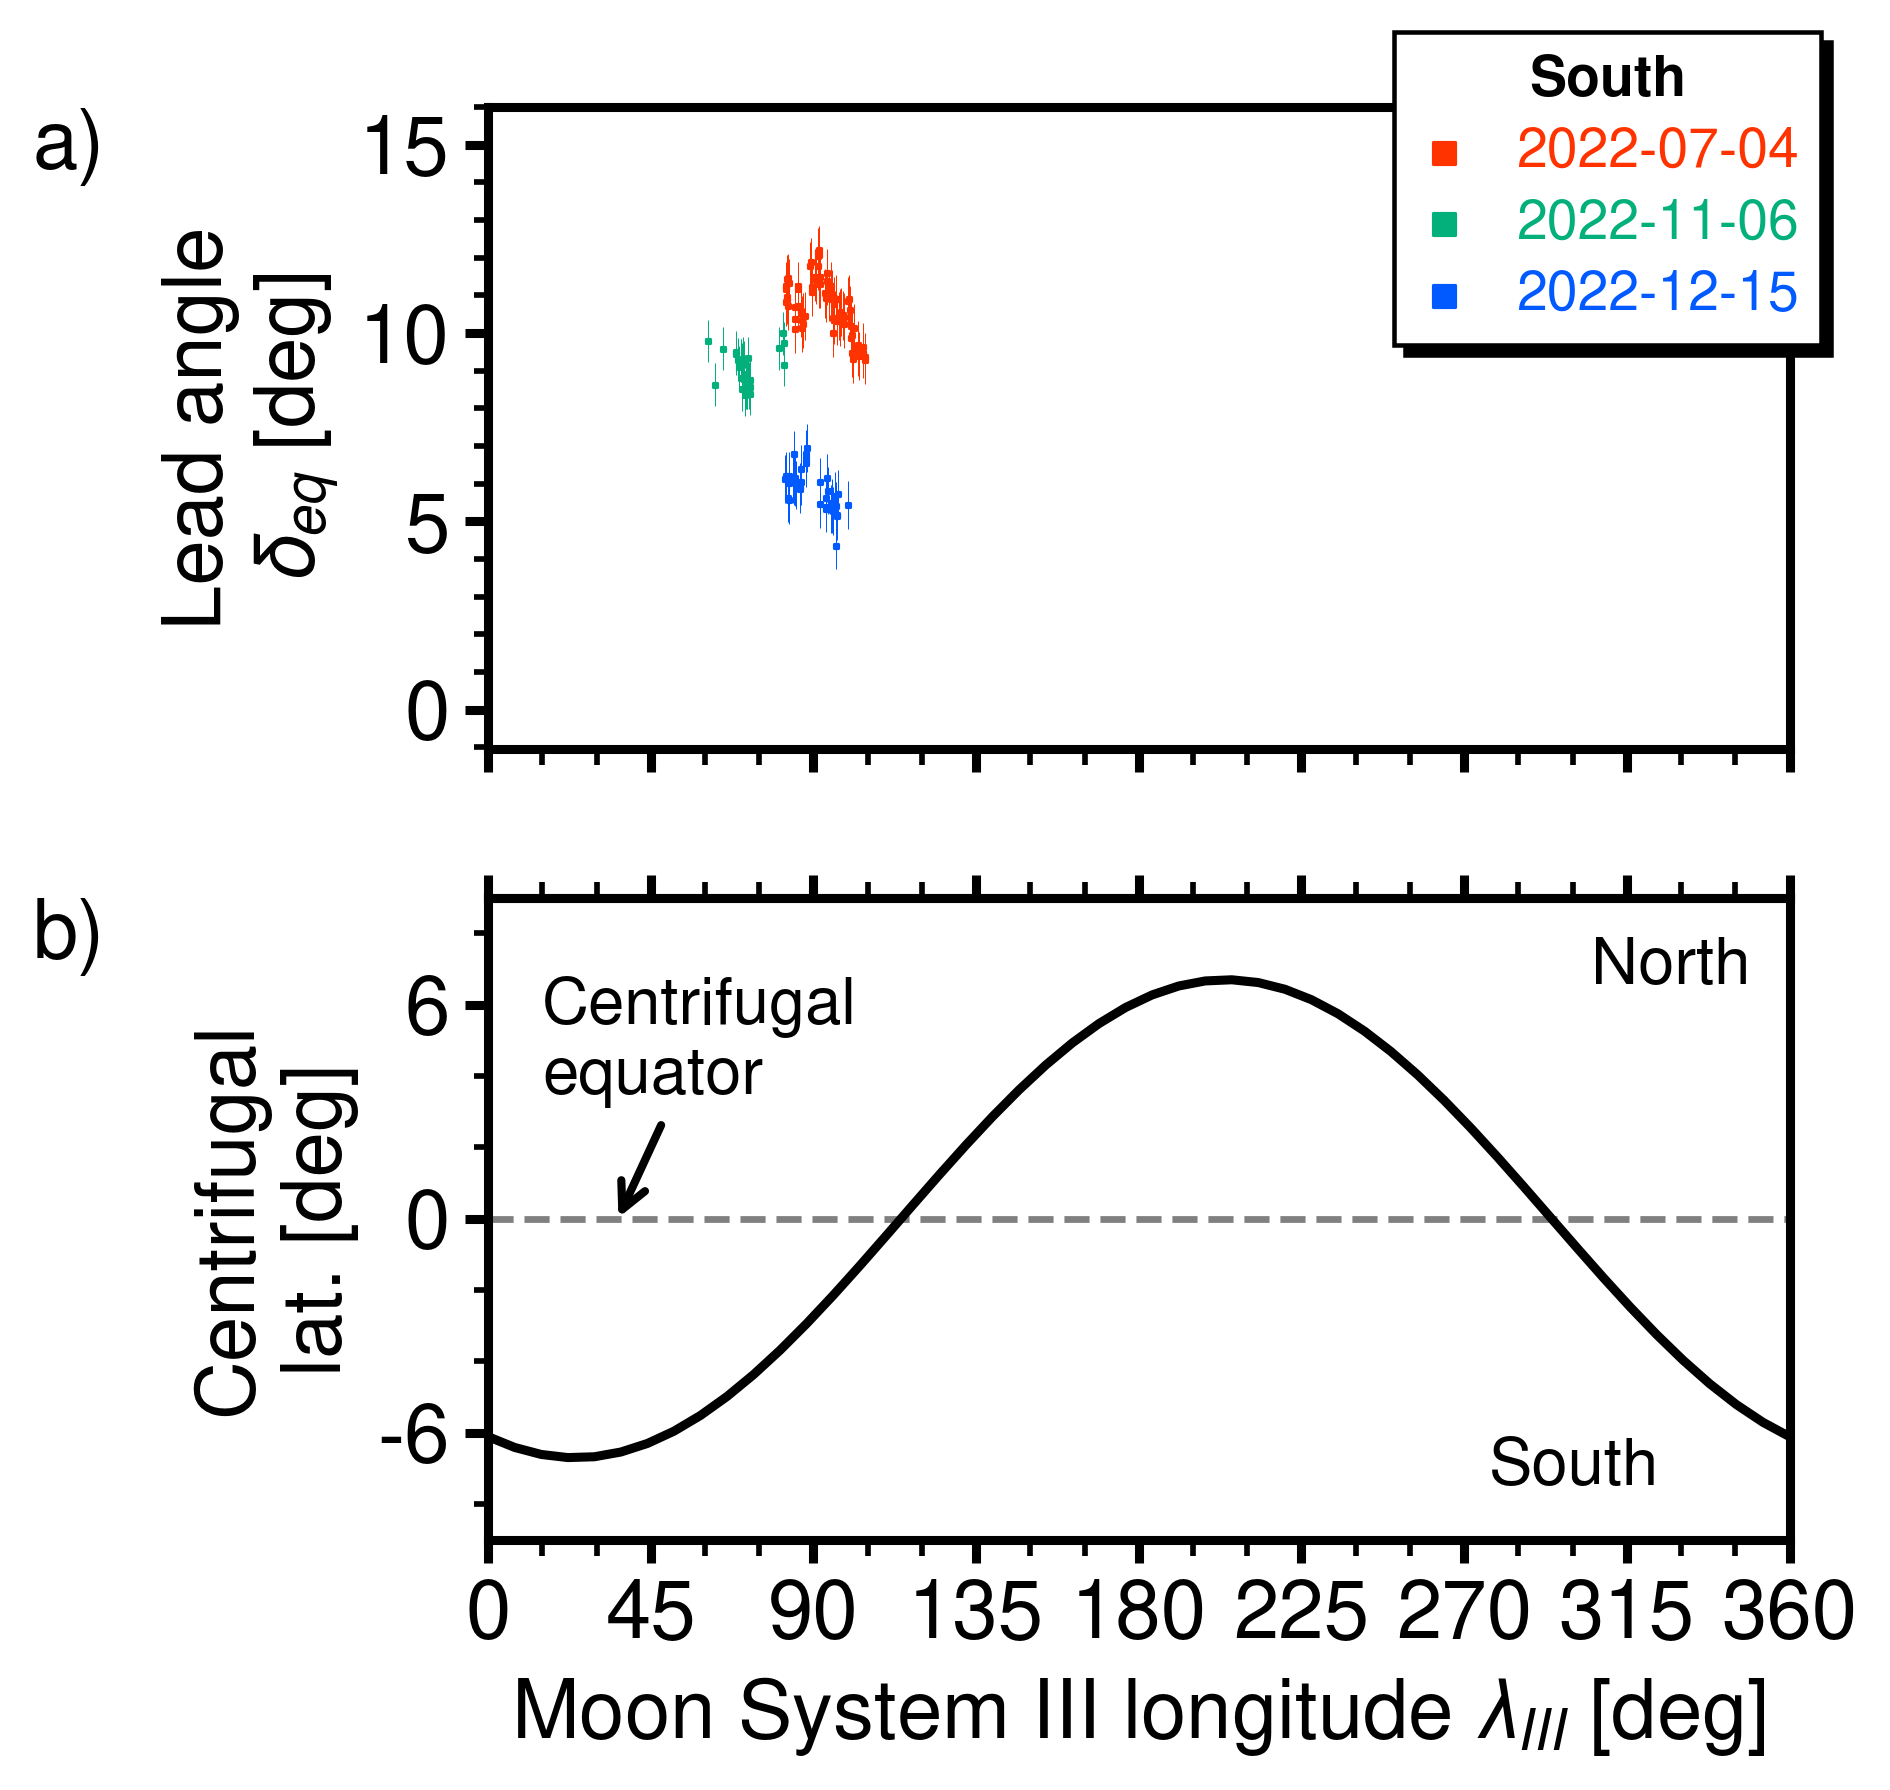

In [70]:
fsize = 18
fig, ax = plt.subplots(2, 1, figsize=(4.7, 5), dpi=326,
                       height_ratios=[1, 1])
# plt.subplots_adjust(left=0.2, top=0.95)
fig.tight_layout()
panelname = ['a','b','c','d','e','f','g','h']
for i in range(ax.size):
    ax[i].set_xlim(0, 360)
    ax[i].tick_params(axis='y', labelsize=fsize)
    ax[i].set_xticks(np.arange(0, 361, 45))
    ax[i].set_xticklabels(np.arange(0, 361, 45), fontsize=fsize)
    ax[i].xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
    if i != 0:
        ax2 = ax[i].secondary_xaxis('top')
        ax2.set_xticks(np.arange(0, 361, 45))
        ax2.set_xticklabels(np.arange(0, 361, 45), fontsize=fsize)
        ax2.xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
        plt.setp(ax2.get_xticklabels(), visible=False)  # ラベルを消す
    if i != ax.size-1:
        plt.setp(ax[i].get_xticklabels(), visible=False)  # ラベルを消す
    ax[i].text(-0.35, 1.0, panelname[i]+')', color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[i].transAxes,
           fontsize=fsize)


for i in [0,1]:
    ax[i].set_ylim(-1.05, 16)
    ax[i].set_ylabel('Lead angle\n$\delta_{eq}$ [deg]', fontsize=fsize)
    ax[i].set_yticks(np.arange(0, 16, 5))
    ax[i].set_yticklabels(np.arange(0, 16, 5))
    ax[i].yaxis.set_minor_locator(AutoMinorLocator(5))  # minor ticks

"""
# North - 2014
cud4_14 = [cud4[0], cud4[2], cud4[3]]
doyname = ['2014-01-06', '2014-01-13', '2014-01-16']
la_err = np.array([1.0614052546455, 1.1145213015136, 0.8732066510795])
for i in range(len(north_doy14)):
    data_arr = np.loadtxt('data/red3_leadangle/EUROPA/20'+north_doy14[i]+'_eq.txt')
    moons30_arr = data_arr[0,:]    # moon s3 longitude [deg]
    eq_leadangle = data_arr[1,:]   # lead angle [deg]
    ax[0].scatter(moons30_arr, eq_leadangle, marker=',', s=0.9, c=cud4_14[i],
                  label=str(doyname[i]), linewidths=0.65, zorder=1)
    ax[0].errorbar(moons30_arr, eq_leadangle, yerr=la_err[i]*np.ones(moons30_arr.shape),
                   linestyle='none', ecolor=cud4_14[i], elinewidth=0.22, marker='none', zorder=1)

# North - 2022
cud4_22 = [cud4[5], cud4[7]]
doyname = ['2022-09-28', '2022-10-01']
la_err = np.array([1.0478863038047, 0.8994575700965])
for i in range(len(north_doy22)):
    data_arr = np.loadtxt('data/red3_leadangle/EUROPA/20'+north_doy22[i]+'_eq.txt')
    moons30_arr = data_arr[0,:]   # moon s3 longitude [deg]
    eq_leadangle = data_arr[1,:]   # lead angle [deg]
    ax[0].scatter(moons30_arr, eq_leadangle, marker=',', s=0.9, c=cud4_22[i],
                  label=str(doyname[i]), linewidths=0.7, zorder=1.5)
    ax[0].errorbar(moons30_arr, eq_leadangle, yerr=la_err[i]*np.ones(moons30_arr.shape),
                   linestyle='none', ecolor=cud4_22[i], elinewidth=0.22, marker='none', zorder=1.5)

legend_fsize = fsize*0.68
legend1 = ax[0].legend(loc='upper center',
                       ncol=1,
                       markerscale=5,
                    bbox_to_anchor=(0.86, 1.16),
                    fancybox=False,
                    facecolor='white',
                    framealpha=1,
                    edgecolor='k',
                    fontsize=legend_fsize,
                    labelspacing=0.34,
                    handlelength=1,)
legend1.set_title('North', prop={'size': legend_fsize, 'weight': 'bold'})
legend_shadow(fig, ax[0], legend1, dx=0.007, dy=-0.006)

# get contour colors
i = 0
for leg1text in legend1.get_texts():
    leg1text.set_color((cud4_14+cud4_22)[i])
    i += 1
"""

# South - 2022
cud4_22 = [cud4[0], cud4[2], cud4[3]]
doyname = ['2022-07-04', '2022-11-06', '2022-12-15']
la_err = np.array([0.6379928352107, 0.56611511426765, 0.6325058969635])
for i in range(len(south_doy)):
    data_arr = np.loadtxt('data/red3_leadangle/EUROPA/20'+south_doy[i]+'R_eq.txt')
    moons30_arr = data_arr[0,:]   # moon s3 longitude [deg]
    eq_leadangle = data_arr[1,:]   # lead angle [deg]
    ax[0].scatter(moons30_arr, eq_leadangle, marker=',', s=0.9, c=cud4_22[i],
                  label=str(doyname[i]), linewidths=0.7, zorder=1)
    ax[0].errorbar(moons30_arr, eq_leadangle, yerr=la_err[i]*np.ones(moons30_arr.shape),
                   linestyle='none', ecolor=cud4_22[i], elinewidth=0.22, marker='none', zorder=1.5)
    
legend1 = ax[0].legend(loc='upper center',
                       ncol=1,
                       markerscale=5,
                    bbox_to_anchor=(0.86, 1.16),
                    fancybox=False,
                    facecolor='white',
                    framealpha=1,
                    edgecolor='k',
                    fontsize=legend_fsize,
                    labelspacing=0.34,
                    handlelength=1,)
legend1.set_title('South', prop={'size': legend_fsize, 'weight': 'bold'})
legend_shadow(fig, ax[0], legend1, dx=0.007, dy=-0.006)

# get contour colors
i = 0
for leg1text in legend1.get_texts():
    leg1text.set_color(cud4_22[i])
    i += 1



# ax[2].set_title(MOON+' - Lead Angle Estimation', weight='bold', fontsize=fsize)
ax[1].set_ylim(-9.0, 9.0)
ax[1].set_ylabel('Centrifugal\nlat. [deg]', fontsize=fsize)
ax[1].set_yticks(np.arange(-6, 7, 6))
ax[1].set_yticklabels(np.arange(-6, 7, 6))
ax[1].yaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
ax[1].plot(np.degrees(S3wlon), lat_cent, linewidth=2, color='k')
ax[1].axhline(y=0, color='gray', linestyle='dashed', zorder=0.5)
ax[1].annotate('Centrifugal\nequator', fontsize=fsize*0.8,
               xy=(35, -0.2), xytext=(15, 3.5), xycoords='data', ha='left',
               arrowprops=dict(arrowstyle='->', connectionstyle='arc3', fc='white', lw=1.8, ec='k', clip_on=True))
ax[1].text(0.97, 0.94,
           'North',
           color='k',
           horizontalalignment='right',
           verticalalignment='top',
           transform=ax[1].transAxes,
           fontsize=fsize*0.8)
ax[1].text(0.90, 0.16,
           'South',
           color='k',
           horizontalalignment='right',
           verticalalignment='top',
           transform=ax[1].transAxes,
           fontsize=fsize*0.8)


ax[1].set_xlabel("Moon System III longitude $\\lambda_{III}$ [deg]", fontsize=fsize)

plt.show()

# 等高線

(array([20]), array([40])) rho_min [1703.49766284] Ti_min [72.49782206]
(array([30]), array([51])) rho_min [2746.3262062] Ti_min [138.02966758]


[]

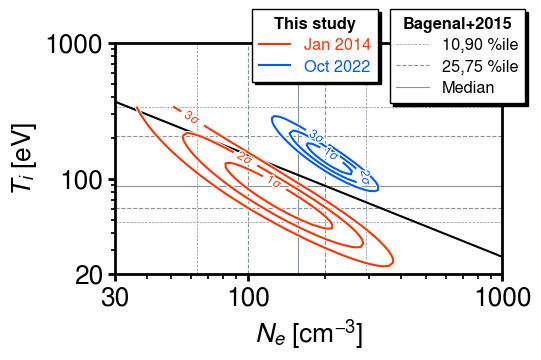

In [71]:
# Galieo fit - Bagenal+2015
Ne_fit = np.linspace(30, 1000, 20)
Ti_fit = 370*((30/Ne_fit)**0.75)

# Plot
fontsize = 19
fig, ax = plt.subplots(figsize=(5,3), dpi=100)
ax.tick_params(axis='both', which='both', labelsize=fontsize)
ax.set_xlabel('$N_e$ [cm$^{-3}$]', fontsize=fontsize)
ax.set_ylabel('$T_i$ [eV]', fontsize=fontsize)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(30,1000)
ax.set_ylim(20,1000)
ax.set_xticks(np.array([30,100,1000], dtype=int))
ax.set_xticklabels(np.array([30,100,1000], dtype=int))
ax.set_yticks(np.array([20,100,1000], dtype=int))
ax.set_yticklabels(np.array([20,100,1000], dtype=int))

yr = ['14', '22']
redblue = [cud4[0], cud4[3]]
cn_list = []
for i in range(2):
    chi2 = np.loadtxt('img/LeadangleFit/20'+yr[i]+'_8/params_chi2.txt')
    RHO0 = np.loadtxt('img/LeadangleFit/20'+yr[i]+'_8/params_RHO0.txt')
    Ti0 = np.loadtxt('img/LeadangleFit/20'+yr[i]+'_8/params_Ti0.txt')

    # chi square 0 is not true value.
    chi2min = np.min(chi2[np.where(chi2>0)])
    chi2min_pos = np.where(chi2==chi2min)
    chi2max = np.max(chi2[np.where(chi2>0)])
    chi2ave = np.average(chi2[np.where(chi2>0)])
    chi2[np.where(chi2==0)] = np.nan
    print(chi2min_pos, 'rho_min', RHO0[chi2min_pos], 'Ti_min', Ti0[chi2min_pos])

    # ax.scatter(chi2min_pos[1], chi2min_pos[0], marker='*', color=redblue[i], zorder=3)
    cn = ax.contour((RHO0/Ai)*Zi, Ti0, chi2,
                    levels=[chi2min+2.30, chi2min+6.17, chi2min+11.8],
                    colors=redblue[i],
                    linewidths=1.5,
                    zorder=2)
    cn.levels = [r'$1\sigma$', r'$2\sigma$', r'$3\sigma$']
    cl = ax.clabel(cn, cn.levels, inline=True, fontsize=fontsize*0.45)
    # Line stroke around clabels
    plt.setp(cl, path_effects=[pe.withStroke(linewidth=2., foreground='white')])
    # Line stroke around contour
    plt.setp(cn.collections, path_effects=[pe.withStroke(linewidth=3, foreground="w")])
    cn_list.append(cn)

ax.plot(Ne_fit, Ti_fit, color='k', zorder=1.5)
ax.axhline(y=340, color=cud4bs[7], linewidth=0.5, label='10,90 %ile', linestyle='dashed', zorder=0.9)  # H/C
ax.axvline(x=63, color=cud4bs[7], linewidth=0.5, linestyle='dashed', zorder=0.9)   # H/C
ax.axhline(y=205, color=cud4bs[7], linewidth=0.8, label='25,75 %ile', linestyle='dashed', zorder=0.9)    # 75
ax.axvline(x=100, color=cud4bs[7], linewidth=0.8, linestyle='dashed', zorder=0.9)    # 25
ax.axhline(y=88, color=cud4bs[7], linewidth=0.8, label='Median', zorder=0.9)  # Medium
ax.axvline(x=158, color=cud4bs[7], linewidth=0.8, zorder=0.9)                        # Medium
ax.axhline(y=61, color=cud4bs[7], linewidth=0.8, linestyle='dashed', zorder=0.9)     # 25
ax.axvline(x=200, color=cud4bs[7], linewidth=0.8, linestyle='dashed', zorder=0.9)    # 75
ax.axhline(y=48, color=cud4bs[7], linewidth=0.5, linestyle='dashed', zorder=0.9)   # L/H
ax.axvline(x=290, color=cud4bs[7], linewidth=0.5, linestyle='dashed', zorder=0.9)  # L/H

# first legend
legend1 = ax.legend(loc='upper right',
                    bbox_to_anchor=(1.08, 1.18),
                    fancybox=False,
                    facecolor='white',
                    framealpha=1,
                    edgecolor='k',
                    fontsize=fontsize*0.62,
                    labelspacing=0.34,)
legend1.set_title('Bagenal+2015', prop={'size': fontsize*0.62, 'weight': 'bold'})
legend_shadow(fig, ax, legend1, dx=0.006, dy=-0.009)

# second legend
h1,_ = cn_list[0].legend_elements()
h2,_ = cn_list[1].legend_elements()
legend2 = ax.legend([h1[0],h2[0]],['Jan 2014','Oct 2022'],
                    loc='upper right',
                    bbox_to_anchor=(0.7, 1.18),
                    fancybox=False,
                    facecolor='white',
                    framealpha=1,
                    edgecolor='k',
                    fontsize=fontsize*0.62,
                    labelspacing=0.34,)
legend2.set_title('This study', prop={'size': fontsize*0.62, 'weight': 'bold'})
legend_shadow(fig, ax, legend2, dx=0.006, dy=-0.009)

# get contour colors
i = 0
for leg2text in legend2.get_texts():
    leg2text.set_color(redblue[i])
    i += 1

ax.add_artist(legend1)

plt.plot()

# HST NORTH

(array([20]), array([40])) rho_min [1703.49766284] Ti_min [72.49782206]
(array([30]), array([51])) rho_min [2746.3262062] Ti_min [138.02966758]


[]

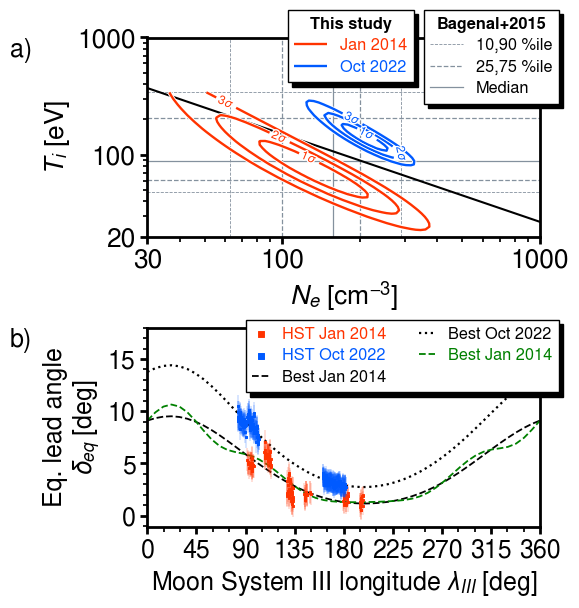

In [72]:
# Galieo fit - Bagenal+2015
Ne_fit = np.linspace(30, 1000, 20)
Ti_fit = 370*((30/Ne_fit)**0.75)

# Plot
fontsize = 19
fig, ax = plt.subplots(2,1, figsize=(6.2,6), dpi=100)
panelname = ['a','b','c','d','e','f','g','h']
for i in range(ax.size):
    ax[i].tick_params(axis='x', labelsize=fsize)
    ax[i].tick_params(axis='y', labelsize=fsize)
    ax[i].text(-0.35, 1.0, panelname[i]+')', color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[i].transAxes,
           fontsize=fsize)

# ==========
# FIRST PLOT
# ==========
ax[0].tick_params(axis='both', which='both', labelsize=fontsize)
ax[0].set_xlabel('$N_e$ [cm$^{-3}$]', fontsize=fontsize)
ax[0].set_ylabel('$T_i$ [eV]', fontsize=fontsize)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlim(30,1000)
ax[0].set_ylim(20,1000)
ax[0].set_xticks(np.array([30,100,1000], dtype=int))
ax[0].set_xticklabels(np.array([30,100,1000], dtype=int))
ax[0].set_yticks(np.array([20,100,1000], dtype=int))
ax[0].set_yticklabels(np.array([20,100,1000], dtype=int))

yr = ['14', '22']
redblue = [cud4[0], cud4[3]]
cn_list = []
for i in range(2):
    chi2 = np.loadtxt('img/LeadangleFit/20'+yr[i]+'_8/params_chi2.txt')
    RHO0 = np.loadtxt('img/LeadangleFit/20'+yr[i]+'_8/params_RHO0.txt')
    Ti0 = np.loadtxt('img/LeadangleFit/20'+yr[i]+'_8/params_Ti0.txt')

    # chi square 0 is not true value.
    chi2min = np.min(chi2[np.where(chi2>0)])
    chi2min_pos = np.where(chi2==chi2min)
    chi2max = np.max(chi2[np.where(chi2>0)])
    chi2ave = np.average(chi2[np.where(chi2>0)])
    chi2[np.where(chi2==0)] = np.nan
    print(chi2min_pos, 'rho_min', RHO0[chi2min_pos], 'Ti_min', Ti0[chi2min_pos])

    # ax.scatter(chi2min_pos[1], chi2min_pos[0], marker='*', color=redblue[i], zorder=3)
    cn = ax[0].contour((RHO0/Ai)*Zi, Ti0, chi2,
                    levels=[chi2min+2.30, chi2min+6.17, chi2min+11.8],
                    colors=redblue[i],
                    linewidths=1.7,
                    zorder=2)
    cn.levels = [r'$1\sigma$', r'$2\sigma$', r'$3\sigma$']
    cl = ax[0].clabel(cn, cn.levels, inline=True, fontsize=fontsize*0.45)
    # Line stroke around clabels
    plt.setp(cl, path_effects=[pe.withStroke(linewidth=2., foreground='white')])
    # Line stroke around contour
    plt.setp(cn.collections, path_effects=[pe.withStroke(linewidth=3, foreground="w")])
    cn_list.append(cn)


ax[0].plot(Ne_fit, Ti_fit, color='k', zorder=1.5)
ax[0].axhline(y=340, color=cud4bs[7], linewidth=0.6, label='10,90 %ile', linestyle='dashed', zorder=0.9)  # H/C
ax[0].axvline(x=63, color=cud4bs[7], linewidth=0.6, linestyle='dashed', zorder=0.9)   # H/C
ax[0].axhline(y=205, color=cud4bs[7], linewidth=0.9, label='25,75 %ile', linestyle='dashed', zorder=0.9)    # 75
ax[0].axvline(x=100, color=cud4bs[7], linewidth=0.9, linestyle='dashed', zorder=0.9)    # 25
ax[0].axhline(y=88, color=cud4bs[7], linewidth=0.9, label='Median', zorder=0.9)  # Medium
ax[0].axvline(x=158, color=cud4bs[7], linewidth=0.9, zorder=0.9)                        # Medium
ax[0].axhline(y=61, color=cud4bs[7], linewidth=0.9, linestyle='dashed', zorder=0.9)     # 25
ax[0].axvline(x=200, color=cud4bs[7], linewidth=0.9, linestyle='dashed', zorder=0.9)    # 75
ax[0].axhline(y=48, color=cud4bs[7], linewidth=0.6, linestyle='dashed', zorder=0.9)   # L/H
ax[0].axvline(x=290, color=cud4bs[7], linewidth=0.6, linestyle='dashed', zorder=0.9)  # L/H


# ===========
# SECOND PLOT
# ===========
ax[1].set_xlabel("Moon System III longitude $\\lambda_{III}$ [deg]", fontsize=fsize)
ax[1].set_xlim(0, 360)
ax[1].set_xticks(np.arange(0, 361, 45))
ax[1].set_xticklabels(np.arange(0, 361, 45), fontsize=fsize)
ax[1].xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
ax[1].set_ylim(-1.05, 18)
ax[1].set_ylabel('Eq. lead angle\n$\delta_{eq}$ [deg]', fontsize=fsize)
ax[1].set_yticks(np.arange(0, 18, 5))
ax[1].set_yticklabels(np.arange(0, 18, 5))
ax[1].yaxis.set_minor_locator(AutoMinorLocator(5))  # minor ticks

# North - 2014
cud4_14 = [cud4[0], cud4[2], cud4[3]]
doyname = ['2014-01-06', '2014-01-13', '2014-01-16']
la_err = np.array([1.0614052546455, 1.1145213015136, 0.8732066510795])
for i in range(len(north_doy14)):
    data_arr = np.loadtxt('data/red3_leadangle/EUROPA/20'+north_doy14[i]+'_eq.txt')
    moons30_arr = data_arr[0,:]    # moon s3 longitude [deg]
    eq_leadangle = data_arr[1,:]   # lead angle [deg]
    sc14 = ax[1].scatter(moons30_arr, eq_leadangle, marker=',', s=0.9, c=cud4[0],
                linewidths=0.65, zorder=1)
    ax[1].errorbar(moons30_arr, eq_leadangle, yerr=la_err[i]*np.ones(moons30_arr.shape),
                linestyle='none', ecolor=cud4[0], elinewidth=0.22, marker='none', zorder=1)
    if i == 0:
        sc14.set_label('HST Jan 2014')
        
# North - 2022
cud4_22 = [cud4[5], cud4[7]]
doyname = ['2022-09-28', '2022-10-01']
la_err = np.array([1.0478863038047, 0.8994575700965])
for i in range(len(north_doy22)):
    data_arr = np.loadtxt('data/red3_leadangle/EUROPA/20'+north_doy22[i]+'_eq.txt')
    moons30_arr = data_arr[0,:]   # moon s3 longitude [deg]
    eq_leadangle = data_arr[1,:]   # lead angle [deg]
    sc22 = ax[1].scatter(moons30_arr, eq_leadangle, marker=',', s=0.9, c=cud4[3],
                  linewidths=0.7, zorder=1.5)
    ax[1].errorbar(moons30_arr, eq_leadangle, yerr=la_err[i]*np.ones(moons30_arr.shape),
                   linestyle='none', ecolor=cud4[3], elinewidth=0.22, marker='none', zorder=1.5)
    if i == 0:
        sc22.set_label('HST Oct 2022')

# Bestfit - 2014 North
data = np.loadtxt('bestfit14_8_N.txt')
ax[1].plot(np.degrees(data[0,:]), data[1,:],
           linestyle='dashed', linewidth=1.3, color='k',
           label='Best Jan 2014', zorder=0.8)

# Bestfit - 2022 North
data = np.loadtxt('bestfit22_8_N.txt')
ax[1].plot(np.degrees(data[0,:]), data[1,:],
           linestyle='dotted', linewidth=1.6, color='k',
           label='Best Oct 2022', zorder=0.8)

# Bestfit - 2014 密度振動
data = np.loadtxt('bestfit14_8_N_double.txt')
ax[1].plot(np.degrees(data[0,:]), data[1,:],
           linestyle='dashed', linewidth=1.3, color='g',
           label='Best Jan 2014', zorder=0.8)


fig.tight_layout()


# =====================
# LEGEND FOR FIRST PLOT
# =====================
legend1 = ax[0].legend(loc='upper right',
                    bbox_to_anchor=(1.07, 1.18),
                    fancybox=False,
                    facecolor='white',
                    framealpha=1,
                    edgecolor='k',
                    fontsize=fontsize*0.62,
                    labelspacing=0.34,)
legend1.set_title('Bagenal+2015', prop={'size': fontsize*0.62, 'weight': 'bold'})
legend_shadow(fig, ax[0], legend1, dx=0.006, dy=-0.0075)

h1,_ = cn_list[0].legend_elements()
h2,_ = cn_list[1].legend_elements()
legend2 = ax[0].legend([h1[0],h2[0]],['Jan 2014','Oct 2022'],
                    loc='upper right',
                    bbox_to_anchor=(0.7, 1.18),
                    fancybox=False,
                    facecolor='white',
                    framealpha=1,
                    edgecolor='k',
                    fontsize=fontsize*0.62,
                    labelspacing=0.34,)
legend2.set_title('This study', prop={'size': fontsize*0.62, 'weight': 'bold'})
legend_shadow(fig, ax[0], legend2, dx=0.006, dy=-0.0075)

# get contour colors
i = 0
for leg2text in legend2.get_texts():
    leg2text.set_color(redblue[i])
    i += 1

ax[0].add_artist(legend1)

# ======================
# LEGEND FOR SECOND PLOT
# ======================
legend3 = ax[1].legend(loc='upper right',
                    ncol=2,
                    markerscale=5,
                    bbox_to_anchor=(1.07, 1.08),
                    fancybox=False,
                    facecolor='white',
                    framealpha=1,
                    edgecolor='k',
                    fontsize=fontsize*0.62,
                    labelspacing=0.34,
                    handlelength=1,)
# legend1.set_title('Bagenal+2015', prop={'size': fontsize*0.62, 'weight': 'bold'})
legend_shadow(fig, ax[1], legend3, dx=0.006, dy=-0.0075)

# get plot colors
i = 0
txtcolor = [cud4[0], cud4[3], 'k', 'k', 'g']
for legtext in legend3.get_texts():
    legtext.set_color(txtcolor[i])
    i += 1

plt.plot()

# HST SOUTH

(array([20]), array([40])) rho_min [1703.49766284] Ti_min [72.49782206]
(array([30]), array([51])) rho_min [2746.3262062] Ti_min [138.02966758]
22/185_v09 size 80
22/310_v19 size 35
22/349_v23 size 40


[]

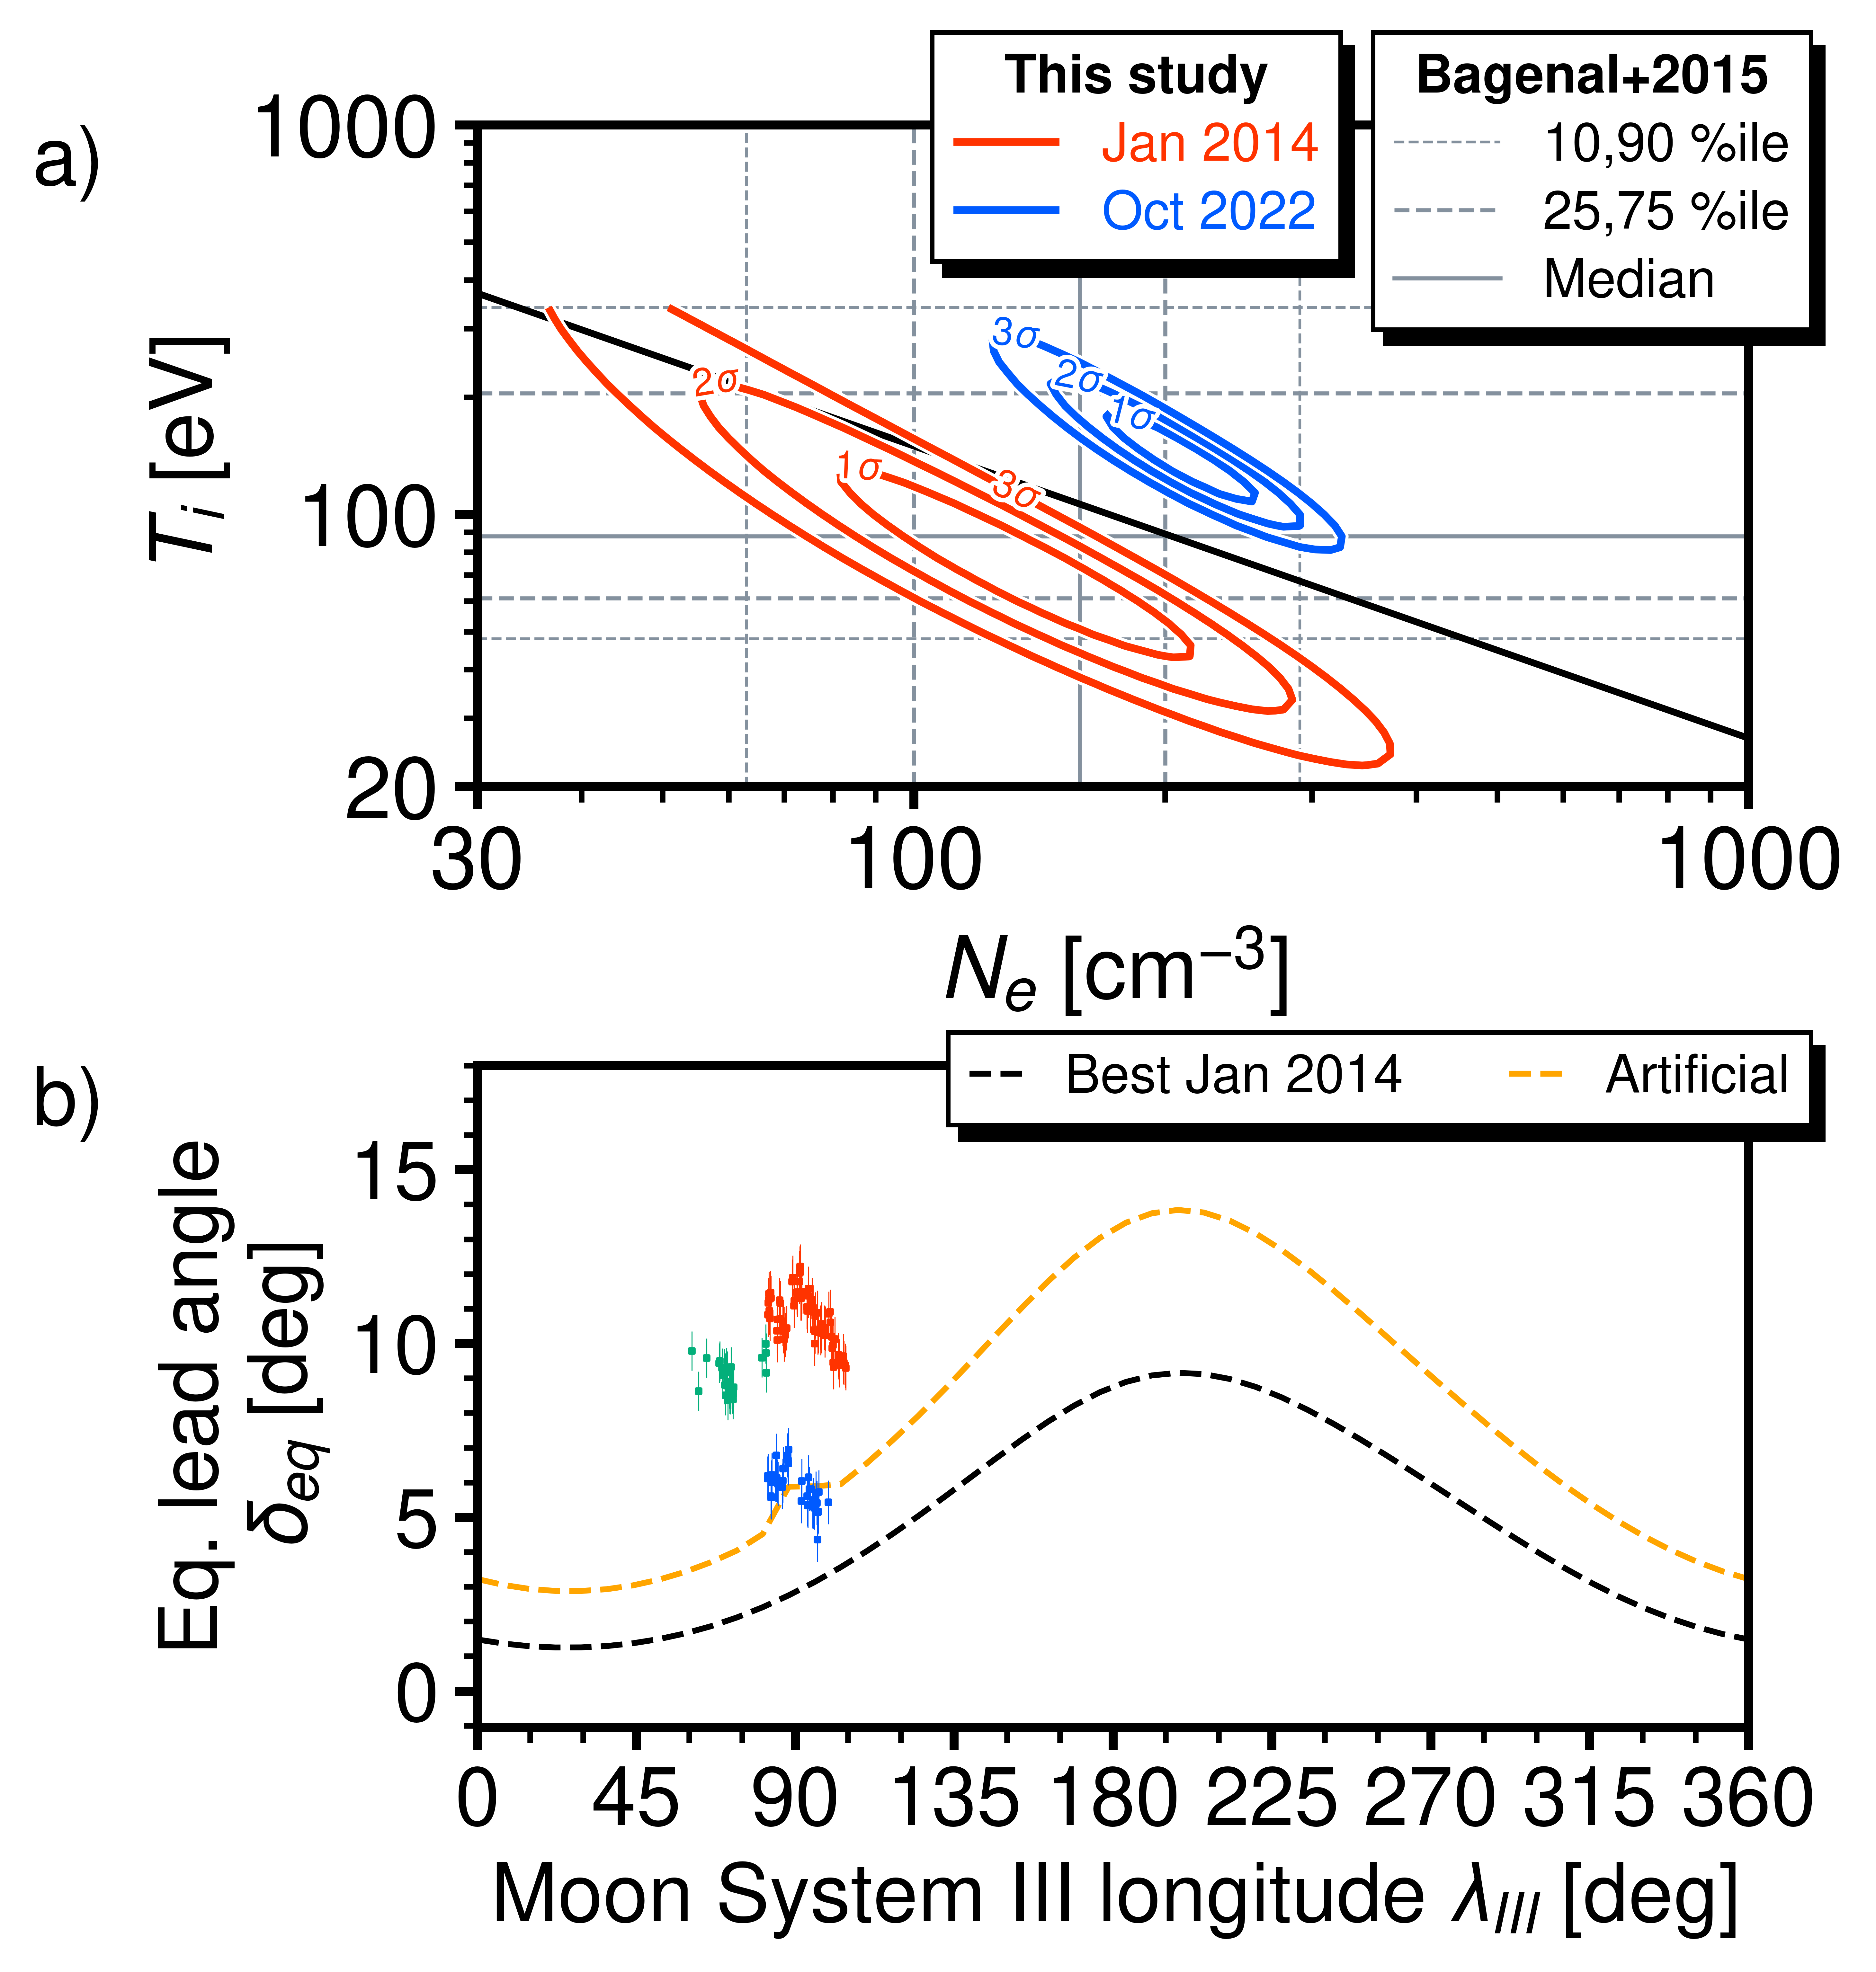

In [73]:
# Galieo fit - Bagenal+2015
Ne_fit = np.linspace(30, 1000, 20)
Ti_fit = 370*((30/Ne_fit)**0.75)

# Plot
fontsize = 19
fig, ax = plt.subplots(2,1, figsize=(6.2,6), dpi=1008)
panelname = ['a','b','c','d','e','f','g','h']
for i in range(ax.size):
    ax[i].tick_params(axis='x', labelsize=fsize)
    ax[i].tick_params(axis='y', labelsize=fsize)
    ax[i].text(-0.35, 1.0, panelname[i]+')', color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[i].transAxes,
           fontsize=fsize)

# ==========
# FIRST PLOT
# ==========
ax[0].tick_params(axis='both', which='both', labelsize=fontsize)
ax[0].set_xlabel('$N_e$ [cm$^{-3}$]', fontsize=fontsize)
ax[0].set_ylabel('$T_i$ [eV]', fontsize=fontsize)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlim(30,1000)
ax[0].set_ylim(20,1000)
ax[0].set_xticks(np.array([30,100,1000], dtype=int))
ax[0].set_xticklabels(np.array([30,100,1000], dtype=int))
ax[0].set_yticks(np.array([20,100,1000], dtype=int))
ax[0].set_yticklabels(np.array([20,100,1000], dtype=int))

yr = ['14', '22']
redblue = [cud4[0], cud4[3]]
cn_list = []
for i in range(2):
    chi2 = np.loadtxt('img/LeadangleFit/20'+yr[i]+'_8/params_chi2.txt')
    RHO0 = np.loadtxt('img/LeadangleFit/20'+yr[i]+'_8/params_RHO0.txt')
    Ti0 = np.loadtxt('img/LeadangleFit/20'+yr[i]+'_8/params_Ti0.txt')

    # chi square 0 is not true value.
    chi2min = np.min(chi2[np.where(chi2>0)])
    chi2min_pos = np.where(chi2==chi2min)
    chi2max = np.max(chi2[np.where(chi2>0)])
    chi2ave = np.average(chi2[np.where(chi2>0)])
    chi2[np.where(chi2==0)] = np.nan
    print(chi2min_pos, 'rho_min', RHO0[chi2min_pos], 'Ti_min', Ti0[chi2min_pos])

    # ax.scatter(chi2min_pos[1], chi2min_pos[0], marker='*', color=redblue[i], zorder=3)
    cn = ax[0].contour((RHO0/Ai)*Zi, Ti0, chi2,
                    levels=[chi2min+2.30, chi2min+6.17, chi2min+11.8],
                    colors=redblue[i],
                    linewidths=1.7,
                    zorder=2)
    cn.levels = [r'$1\sigma$', r'$2\sigma$', r'$3\sigma$']
    cl = ax[0].clabel(cn, cn.levels, inline=True, fontsize=fontsize*0.45)
    # Line stroke around clabels
    plt.setp(cl, path_effects=[pe.withStroke(linewidth=2., foreground='white')])
    # Line stroke around contour
    plt.setp(cn.collections, path_effects=[pe.withStroke(linewidth=3, foreground="w")])
    cn_list.append(cn)


ax[0].plot(Ne_fit, Ti_fit, color='k', zorder=1.5)
ax[0].axhline(y=340, color=cud4bs[7], linewidth=0.6, label='10,90 %ile', linestyle='dashed', zorder=0.9)  # H/C
ax[0].axvline(x=63, color=cud4bs[7], linewidth=0.6, linestyle='dashed', zorder=0.9)   # H/C
ax[0].axhline(y=205, color=cud4bs[7], linewidth=0.9, label='25,75 %ile', linestyle='dashed', zorder=0.9)    # 75
ax[0].axvline(x=100, color=cud4bs[7], linewidth=0.9, linestyle='dashed', zorder=0.9)    # 25
ax[0].axhline(y=88, color=cud4bs[7], linewidth=0.9, label='Median', zorder=0.9)  # Medium
ax[0].axvline(x=158, color=cud4bs[7], linewidth=0.9, zorder=0.9)                        # Medium
ax[0].axhline(y=61, color=cud4bs[7], linewidth=0.9, linestyle='dashed', zorder=0.9)     # 25
ax[0].axvline(x=200, color=cud4bs[7], linewidth=0.9, linestyle='dashed', zorder=0.9)    # 75
ax[0].axhline(y=48, color=cud4bs[7], linewidth=0.6, linestyle='dashed', zorder=0.9)   # L/H
ax[0].axvline(x=290, color=cud4bs[7], linewidth=0.6, linestyle='dashed', zorder=0.9)  # L/H


# ===========
# SECOND PLOT
# ===========
ax[1].set_xlabel("Moon System III longitude $\\lambda_{III}$ [deg]", fontsize=fsize)
ax[1].set_xlim(0, 360)
ax[1].set_xticks(np.arange(0, 361, 45))
ax[1].set_xticklabels(np.arange(0, 361, 45), fontsize=fsize)
ax[1].xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
ax[1].set_ylim(-1.05, 18)
ax[1].set_ylabel('Eq. lead angle\n$\delta_{eq}$ [deg]', fontsize=fsize)
ax[1].set_yticks(np.arange(0, 19, 5))
ax[1].set_yticklabels(np.arange(0, 19, 5))
ax[1].yaxis.set_minor_locator(AutoMinorLocator(5))  # minor ticks
        
# South - 2022
cud4_22 = [cud4[0], cud4[2], cud4[3]]
doyname = ['2022-07-04', '2022-11-06', '2022-12-15']
la_err = np.array([0.6379928352107, 0.56611511426765, 0.6325058969635])
for i in range(len(south_doy)):
    data_arr = np.loadtxt('data/red3_leadangle/EUROPA/20'+south_doy[i]+'R_eq.txt')
    moons30_arr = data_arr[0,:]   # moon s3 longitude [deg]
    eq_leadangle = data_arr[1,:]   # lead angle [deg]
    sc22 = ax[1].scatter(moons30_arr, eq_leadangle, marker=',', s=0.9, c=cud4_22[i],
                  linewidths=0.7, zorder=1.5)
    ax[1].errorbar(moons30_arr, eq_leadangle, yerr=la_err[i]*np.ones(moons30_arr.shape),
                   linestyle='none', ecolor=cud4_22[i], elinewidth=0.22, marker='none', zorder=1.5)
    print(south_doy[i], 'size', moons30_arr.size)

# Bestfit - 2014 North
data = np.loadtxt('bestfit14_S.txt')
ax[1].plot(np.degrees(data[0,:]), data[1,:],
           linestyle='dashed', linewidth=1.3, color='k',
           label='Best Jan 2014', zorder=0.8)

"""
# Bestfit - 2022 North
data = np.loadtxt('bestfit22_S.txt')
ax[1].plot(np.degrees(data[0,:]), data[1,:],
           linestyle='dotted', linewidth=1.6, color='k',
           label='Best Oct 2022', zorder=0.8)
"""
           
"""
# ================
# HUE+2023 FOURIER
# ================
s3wlong_arr = np.radians(np.linspace(0,360,60))
south_eqla = 7.06 - 3.37*np.cos(s3wlong_arr) + 0.15*np.sin(s3wlong_arr)
ax[1].plot(np.degrees(s3wlong_arr), south_eqla,
           linestyle='solid', linewidth=1.6, color='k',
           label='Hue+23', zorder=0.8)"""

# Bestfit - 2014 密度振動
data = np.loadtxt('bestfit14_8_S_double.txt')
ax[1].plot(np.degrees(data[0,:]), data[1,:],
           linestyle='dashed', linewidth=1.3, color='orange',
           label='Artificial', zorder=0.8)


fig.tight_layout()


# =====================
# LEGEND FOR FIRST PLOT
# =====================
legend1 = ax[0].legend(loc='upper right',
                    bbox_to_anchor=(1.07, 1.18),
                    fancybox=False,
                    facecolor='white',
                    framealpha=1,
                    edgecolor='k',
                    fontsize=fontsize*0.62,
                    labelspacing=0.34,)
legend1.set_title('Bagenal+2015', prop={'size': fontsize*0.62, 'weight': 'bold'})
legend_shadow(fig, ax[0], legend1, dx=0.006, dy=-0.0075)

h1,_ = cn_list[0].legend_elements()
h2,_ = cn_list[1].legend_elements()
legend2 = ax[0].legend([h1[0],h2[0]],['Jan 2014','Oct 2022'],
                    loc='upper right',
                    bbox_to_anchor=(0.7, 1.18),
                    fancybox=False,
                    facecolor='white',
                    framealpha=1,
                    edgecolor='k',
                    fontsize=fontsize*0.62,
                    labelspacing=0.34,)
legend2.set_title('This study', prop={'size': fontsize*0.62, 'weight': 'bold'})
legend_shadow(fig, ax[0], legend2, dx=0.006, dy=-0.0075)

# get contour colors
i = 0
for leg2text in legend2.get_texts():
    leg2text.set_color(redblue[i])
    i += 1

ax[0].add_artist(legend1)

# ======================
# LEGEND FOR SECOND PLOT
# ======================
legend3 = ax[1].legend(loc='upper right',
                    ncol=2,
                    markerscale=5,
                    bbox_to_anchor=(1.07, 1.09),
                    fancybox=False,
                    facecolor='white',
                    framealpha=1,
                    edgecolor='k',
                    fontsize=fontsize*0.62,
                    labelspacing=0.34,
                    handlelength=1,)
# legend1.set_title('Bagenal+2015', prop={'size': fontsize*0.62, 'weight': 'bold'})
legend_shadow(fig, ax[1], legend3, dx=0.006, dy=-0.0075)


plt.plot()

(array([59]), array([27])) rho_min [2639.95499372] Ti_min [3600.]
(array([59]), array([27])) rho_min [2639.95499372] Ti_min [3600.]
0.07777777777777778


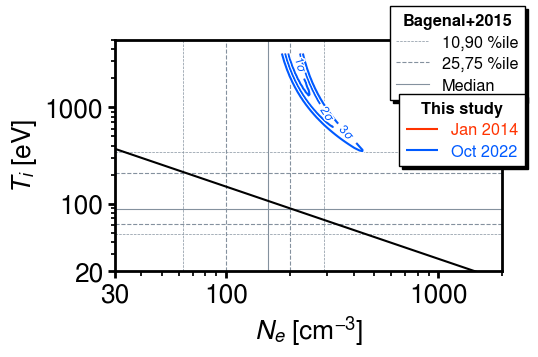

In [74]:
# Galieo fit - Bagenal+2015
Ne_fit = np.linspace(30, 2000, 20)
Ti_fit = 370*((30/Ne_fit)**0.75)

# Plot
fontsize = 19
fig, ax = plt.subplots(figsize=(5,3), dpi=100)
ax.tick_params(axis='both', which='both', labelsize=fontsize)
ax.set_xlabel('$N_e$ [cm$^{-3}$]', fontsize=fontsize)
ax.set_ylabel('$T_i$ [eV]', fontsize=fontsize)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(30,2000)
ax.set_ylim(20,5000)
ax.set_xticks(np.array([30,100,1000], dtype=int))
ax.set_xticklabels(np.array([30,100,1000], dtype=int))
ax.set_yticks(np.array([20,100,1000], dtype=int))
ax.set_yticklabels(np.array([20,100,1000], dtype=int))

yr = ['14', '22']
redblue = [cud4[0], cud4[3]]
cn_list = []
for i in range(2):
    chi2 = np.loadtxt('img/LeadangleFit/2218509_2/params_chi2.txt')
    RHO0 = np.loadtxt('img/LeadangleFit/2218509_2/params_RHO0.txt')
    Ti0 = np.loadtxt('img/LeadangleFit/2218509_2/params_Ti0.txt')

    # chi square 0 is not true value.
    chi2min = np.min(chi2[np.where(chi2>0)])
    chi2min_pos = np.where(chi2==chi2min)
    chi2max = np.max(chi2[np.where(chi2>0)])
    chi2ave = np.average(chi2[np.where(chi2>0)])
    chi2[np.where(chi2==0)] = np.nan
    print(chi2min_pos, 'rho_min', RHO0[chi2min_pos], 'Ti_min', Ti0[chi2min_pos])

    # ax.scatter(chi2min_pos[1], chi2min_pos[0], marker='*', color=redblue[i], zorder=3)
    cn = ax.contour((RHO0/Ai)*Zi, Ti0, chi2,
                    levels=[chi2min+2.30, chi2min+6.17, chi2min+11.8],
                    colors=redblue[i],
                    linewidths=1.5,
                    zorder=2)
    cn.levels = [r'$1\sigma$', r'$2\sigma$', r'$3\sigma$']
    cl = ax.clabel(cn, cn.levels, inline=True, fontsize=fontsize*0.45)
    # Line stroke around clabels
    plt.setp(cl, path_effects=[pe.withStroke(linewidth=2., foreground='white')])
    # Line stroke around contour
    plt.setp(cn.collections, path_effects=[pe.withStroke(linewidth=3, foreground="w")])
    cn_list.append(cn)

ax.plot(Ne_fit, Ti_fit, color='k', zorder=1.5)
ax.axhline(y=340, color=cud4bs[7], linewidth=0.5, label='10,90 %ile', linestyle='dashed', zorder=0.9)  # H/C
ax.axvline(x=63, color=cud4bs[7], linewidth=0.5, linestyle='dashed', zorder=0.9)   # H/C
ax.axhline(y=205, color=cud4bs[7], linewidth=0.8, label='25,75 %ile', linestyle='dashed', zorder=0.9)    # 75
ax.axvline(x=100, color=cud4bs[7], linewidth=0.8, linestyle='dashed', zorder=0.9)    # 25
ax.axhline(y=88, color=cud4bs[7], linewidth=0.8, label='Median', zorder=0.9)  # Medium
ax.axvline(x=158, color=cud4bs[7], linewidth=0.8, zorder=0.9)                        # Medium
ax.axhline(y=61, color=cud4bs[7], linewidth=0.8, linestyle='dashed', zorder=0.9)     # 25
ax.axvline(x=200, color=cud4bs[7], linewidth=0.8, linestyle='dashed', zorder=0.9)    # 75
ax.axhline(y=48, color=cud4bs[7], linewidth=0.5, linestyle='dashed', zorder=0.9)   # L/H
ax.axvline(x=290, color=cud4bs[7], linewidth=0.5, linestyle='dashed', zorder=0.9)  # L/H

# first legend
legend1 = ax.legend(loc='upper right',
                    bbox_to_anchor=(1.08, 1.18),
                    fancybox=False,
                    facecolor='white',
                    framealpha=1,
                    edgecolor='k',
                    fontsize=fontsize*0.62,
                    labelspacing=0.34,)
legend1.set_title('Bagenal+2015', prop={'size': fontsize*0.62, 'weight': 'bold'})
legend_shadow(fig, ax, legend1, dx=0.006, dy=-0.009)

# second legend
h1,_ = cn_list[0].legend_elements()
h2,_ = cn_list[1].legend_elements()
legend2 = ax.legend([h1[0],h2[0]],['Jan 2014','Oct 2022'],
                    loc='upper right',
                    bbox_to_anchor=(1.08, 0.80),
                    fancybox=False,
                    facecolor='white',
                    framealpha=1,
                    edgecolor='k',
                    fontsize=fontsize*0.62,
                    labelspacing=0.34,)
legend2.set_title('This study', prop={'size': fontsize*0.62, 'weight': 'bold'})
legend_shadow(fig, ax, legend2, dx=0.006, dy=-0.009)

# get contour colors
i = 0
for leg2text in legend2.get_texts():
    leg2text.set_color(redblue[i])
    i += 1

ax.add_artist(legend1)

plt.plot()

print(Zi/Ai)

(array([59]), array([60])) rho_min [3971.78287377] Ti_min [700.]
(array([59]), array([60])) rho_min [3971.78287377] Ti_min [700.]
22/185_v09 size 80
22/310_v19 size 35
22/349_v23 size 40


[]

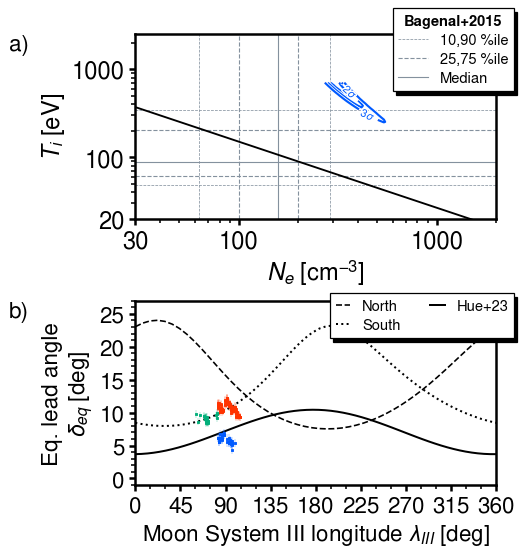

In [75]:
# Galieo fit - Bagenal+2015
Ne_fit = np.linspace(30, 2000, 20)
Ti_fit = 370*((30/Ne_fit)**0.75)

# Plot
fontsize = 19
fig, ax = plt.subplots(2,1, figsize=(6.2,6), dpi=90)
panelname = ['a','b','c','d','e','f','g','h']
for i in range(ax.size):
    ax[i].tick_params(axis='x', labelsize=fsize)
    ax[i].tick_params(axis='y', labelsize=fsize)
    ax[i].text(-0.35, 1.0, panelname[i]+')', color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[i].transAxes,
           fontsize=fsize)

# ==========
# FIRST PLOT
# ==========
ax[0].tick_params(axis='both', which='both', labelsize=fontsize)
ax[0].set_xlabel('$N_e$ [cm$^{-3}$]', fontsize=fontsize)
ax[0].set_ylabel('$T_i$ [eV]', fontsize=fontsize)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlim(30,2000)
ax[0].set_ylim(20,2500)
ax[0].set_xticks(np.array([30,100,1000], dtype=int))
ax[0].set_xticklabels(np.array([30,100,1000], dtype=int))
ax[0].set_yticks(np.array([20,100,1000], dtype=int))
ax[0].set_yticklabels(np.array([20,100,1000], dtype=int))

yr = ['14', '22']
redblue = [cud4[0], cud4[3]]
cn_list = []
for i in range(2):
    chi2 = np.loadtxt('img/LeadangleFit/2218509_1/params_chi2.txt')
    RHO0 = np.loadtxt('img/LeadangleFit/2218509_1/params_RHO0.txt')
    Ti0 = np.loadtxt('img/LeadangleFit/2218509_1/params_Ti0.txt')

    # chi square 0 is not true value.
    chi2min = np.min(chi2[np.where(chi2>0)])
    chi2min_pos = np.where(chi2==chi2min)
    chi2max = np.max(chi2[np.where(chi2>0)])
    chi2ave = np.average(chi2[np.where(chi2>0)])
    chi2[np.where(chi2==0)] = np.nan
    print(chi2min_pos, 'rho_min', RHO0[chi2min_pos], 'Ti_min', Ti0[chi2min_pos])

    # ax.scatter(chi2min_pos[1], chi2min_pos[0], marker='*', color=redblue[i], zorder=3)
    cn = ax[0].contour((RHO0/Ai)*Zi, Ti0, chi2,
                    levels=[chi2min+2.30, chi2min+6.17, chi2min+11.8],
                    colors=redblue[i],
                    linewidths=1.7,
                    zorder=2)
    cn.levels = [r'$1\sigma$', r'$2\sigma$', r'$3\sigma$']
    cl = ax[0].clabel(cn, cn.levels, inline=True, fontsize=fontsize*0.45)
    # Line stroke around clabels
    plt.setp(cl, path_effects=[pe.withStroke(linewidth=2., foreground='white')])
    # Line stroke around contour
    plt.setp(cn.collections, path_effects=[pe.withStroke(linewidth=3, foreground="w")])
    cn_list.append(cn)


ax[0].plot(Ne_fit, Ti_fit, color='k', zorder=1.5)
ax[0].axhline(y=340, color=cud4bs[7], linewidth=0.6, label='10,90 %ile', linestyle='dashed', zorder=0.9)  # H/C
ax[0].axvline(x=63, color=cud4bs[7], linewidth=0.6, linestyle='dashed', zorder=0.9)   # H/C
ax[0].axhline(y=205, color=cud4bs[7], linewidth=0.9, label='25,75 %ile', linestyle='dashed', zorder=0.9)    # 75
ax[0].axvline(x=100, color=cud4bs[7], linewidth=0.9, linestyle='dashed', zorder=0.9)    # 25
ax[0].axhline(y=88, color=cud4bs[7], linewidth=0.9, label='Median', zorder=0.9)  # Medium
ax[0].axvline(x=158, color=cud4bs[7], linewidth=0.9, zorder=0.9)                        # Medium
ax[0].axhline(y=61, color=cud4bs[7], linewidth=0.9, linestyle='dashed', zorder=0.9)     # 25
ax[0].axvline(x=200, color=cud4bs[7], linewidth=0.9, linestyle='dashed', zorder=0.9)    # 75
ax[0].axhline(y=48, color=cud4bs[7], linewidth=0.6, linestyle='dashed', zorder=0.9)   # L/H
ax[0].axvline(x=290, color=cud4bs[7], linewidth=0.6, linestyle='dashed', zorder=0.9)  # L/H


# ===========
# SECOND PLOT
# ===========
ax[1].set_xlabel("Moon System III longitude $\\lambda_{III}$ [deg]", fontsize=fsize)
ax[1].set_xlim(0, 360)
ax[1].set_xticks(np.arange(0, 361, 45))
ax[1].set_xticklabels(np.arange(0, 361, 45), fontsize=fsize)
ax[1].xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
ax[1].set_ylim(-1.05, 27)
ax[1].set_ylabel('Eq. lead angle\n$\delta_{eq}$ [deg]', fontsize=fsize)
ax[1].set_yticks(np.arange(0, 27, 5))
ax[1].set_yticklabels(np.arange(0, 27, 5))
ax[1].yaxis.set_minor_locator(AutoMinorLocator(5))  # minor ticks
        
# South - 2022
cud4_22 = [cud4[0], cud4[2], cud4[3]]
doyname = ['2022-07-04', '2022-11-06', '2022-12-15']
la_err = np.array([0.6379928352107, 0.56611511426765, 0.6325058969635])
for i in range(len(south_doy)):
    data_arr = np.loadtxt('data/red3_leadangle/EUROPA/20'+south_doy[i]+'R_eq.txt')
    moons30_arr = data_arr[0,:]   # moon s3 longitude [deg]
    eq_leadangle = data_arr[1,:]   # lead angle [deg]
    sc22 = ax[1].scatter(moons30_arr, eq_leadangle, marker=',', s=0.9, c=cud4_22[i],
                  linewidths=0.7, zorder=1.5)
    ax[1].errorbar(moons30_arr, eq_leadangle, yerr=la_err[i]*np.ones(moons30_arr.shape),
                   linestyle='none', ecolor=cud4_22[i], elinewidth=0.22, marker='none', zorder=1.5)
    print(south_doy[i], 'size', moons30_arr.size)

# Bestfit - 202218509 North
data = np.loadtxt('bestfit2218509_1_N.txt')
ax[1].plot(np.degrees(data[0,:]), data[1,:],
           linestyle='dashed', linewidth=1.3, color='k',
           label='North', zorder=0.8)

# Bestfit - 202218509 South
data = np.loadtxt('bestfit2218509_1_S.txt')
ax[1].plot(np.degrees(data[0,:]), data[1,:],
           linestyle='dotted', linewidth=1.6, color='k',
           label='South', zorder=0.8)


# ================
# HUE+2023 FOURIER
# ================
s3wlong_arr = np.radians(np.linspace(0,360,60))
south_eqla = 7.06 - 3.37*np.cos(s3wlong_arr) + 0.15*np.sin(s3wlong_arr)
ax[1].plot(np.degrees(s3wlong_arr), south_eqla,
           linestyle='solid', linewidth=1.6, color='k',
           label='Hue+23', zorder=0.8)



fig.tight_layout()


# =====================
# LEGEND FOR FIRST PLOT
# =====================
legend1 = ax[0].legend(loc='upper right',
                    bbox_to_anchor=(1.07, 1.18),
                    fancybox=False,
                    facecolor='white',
                    framealpha=1,
                    edgecolor='k',
                    fontsize=fontsize*0.62,
                    labelspacing=0.34,)
legend1.set_title('Bagenal+2015', prop={'size': fontsize*0.62, 'weight': 'bold'})
legend_shadow(fig, ax[0], legend1, dx=0.006, dy=-0.0075)

"""
h1,_ = cn_list[0].legend_elements()
h2,_ = cn_list[1].legend_elements()
legend2 = ax[0].legend([h1[0],h2[0]],['Jan 2014','Oct 2022'],
                    loc='upper right',
                    bbox_to_anchor=(0.7, 1.18),
                    fancybox=False,
                    facecolor='white',
                    framealpha=1,
                    edgecolor='k',
                    fontsize=fontsize*0.62,
                    labelspacing=0.34,)
legend2.set_title('This study', prop={'size': fontsize*0.62, 'weight': 'bold'})
legend_shadow(fig, ax[0], legend2, dx=0.006, dy=-0.0075)

# get contour colors
i = 0
for leg2text in legend2.get_texts():
    leg2text.set_color(redblue[i])
    i += 1

ax[0].add_artist(legend1)
"""

# ======================
# LEGEND FOR SECOND PLOT
# ======================
legend3 = ax[1].legend(loc='upper right',
                    ncol=2,
                    markerscale=5,
                    bbox_to_anchor=(1.07, 1.08),
                    fancybox=False,
                    facecolor='white',
                    framealpha=1,
                    edgecolor='k',
                    fontsize=fontsize*0.62,
                    labelspacing=0.34,
                    handlelength=1,)
# legend1.set_title('Bagenal+2015', prop={'size': fontsize*0.62, 'weight': 'bold'})
legend_shadow(fig, ax[1], legend3, dx=0.006, dy=-0.0075)


plt.plot()

# Juno PJ26

(array([15]), array([52])) rho_min [2868.18809116] Ti_min [52.54134897]


[]

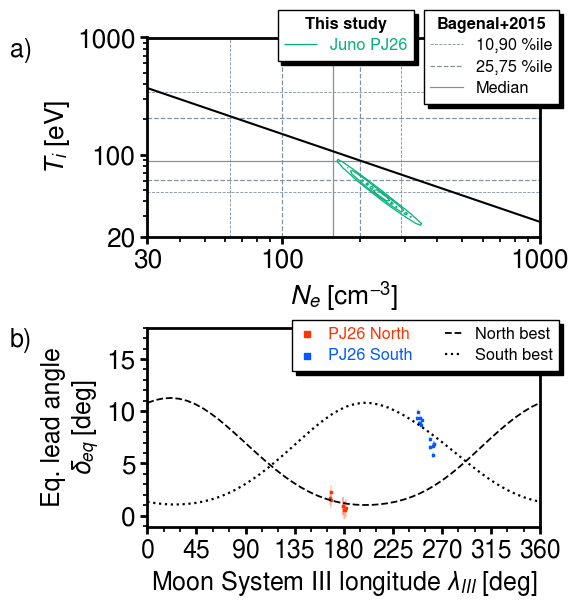

In [76]:
# Galieo fit - Bagenal+2015
Ne_fit = np.linspace(30, 1000, 20)
Ti_fit = 370*((30/Ne_fit)**0.75)

# Northern hemisphere
PJnum = 'PJ26'
data_pd = pd.read_csv('data/Hue23_EFP_north2.txt', skiprows=2,
                        names=['PJ', 'UTC_TIME',
                                'Moon_SIII_LON',
                                'FP_LON',
                                'FP_LAT',
                                'FP_LON_ERR',
                                'FP_LAT_ERR',
                                'EMISSION_ANGLE',
                                'EQ_LEAD_ANGLE',
                                'EQ_LEAD_ANGLE_ERR'],
                        sep=',')
PJdataN = data_pd[data_pd['PJ'].str.contains(PJnum)]

# Southern hemisphere
data_pd = pd.read_csv('data/Hue23_EFP_south2.txt', skiprows=2,
                        names=['PJ', 'UTC_TIME',
                                'Moon_SIII_LON',
                                'FP_LON',
                                'FP_LAT',
                                'FP_LON_ERR',
                                'FP_LAT_ERR',
                                'EMISSION_ANGLE',
                                'EQ_LEAD_ANGLE',
                                'EQ_LEAD_ANGLE_ERR'],
                        sep=',')
PJdataS = data_pd[data_pd['PJ'].str.contains(PJnum)]

# Plot
fontsize = 19
fig, ax = plt.subplots(2,1, figsize=(6.2,6), dpi=100)
panelname = ['a','b','c','d','e','f','g','h']
for i in range(ax.size):
    ax[i].tick_params(axis='x', labelsize=fontsize)
    ax[i].tick_params(axis='y', labelsize=fontsize)
    ax[i].text(-0.35, 1.0, panelname[i]+')', color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[i].transAxes,
           fontsize=fsize)

# ==========
# FIRST PLOT
# ==========
ax[0].tick_params(axis='both', which='both', labelsize=fontsize)
ax[0].set_xlabel('$N_e$ [cm$^{-3}$]', fontsize=fontsize)
ax[0].set_ylabel('$T_i$ [eV]', fontsize=fontsize)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlim(30,1000)
ax[0].set_ylim(20,1000)
ax[0].set_xticks(np.array([30,100,1000], dtype=int))
ax[0].set_xticklabels(np.array([30,100,1000], dtype=int))
ax[0].set_yticks(np.array([20,100,1000], dtype=int))
ax[0].set_yticklabels(np.array([20,100,1000], dtype=int))

yr = ['14', '22']
redblue = [cud4[0], cud4[3]]

chi2 = np.loadtxt('img/LeadangleFit/PJ26/params_chi2.txt')
RHO0 = np.loadtxt('img/LeadangleFit/PJ26/params_RHO0.txt')
Ti0 = np.loadtxt('img/LeadangleFit/PJ26/params_Ti0.txt')

# chi square 0 is not true value.
chi2min = np.min(chi2[np.where(chi2>0)])
chi2min_pos = np.where(chi2==chi2min)
chi2max = np.max(chi2[np.where(chi2>0)])
chi2ave = np.average(chi2[np.where(chi2>0)])
chi2[np.where(chi2==0)] = np.nan
print(chi2min_pos, 'rho_min', RHO0[chi2min_pos], 'Ti_min', Ti0[chi2min_pos])

# ax.scatter(chi2min_pos[1], chi2min_pos[0], marker='*', color=redblue[i], zorder=3)
cn = ax[0].contour((RHO0/Ai)*Zi, Ti0, chi2,
                levels=[chi2min+2.30, chi2min+6.17, chi2min+11.8],
                colors=cud4[2],
                linewidths=0.9,
                zorder=2)
# cn.levels = [r'$1\sigma$', r'$2\sigma$', r'$3\sigma$']
# cl = ax[0].clabel(cn, cn.levels, inline=True, fontsize=fontsize*0.45)
# Line stroke around clabels
# plt.setp(cl, path_effects=[pe.withStroke(linewidth=2., foreground='white')])
# Line stroke around contour
# plt.setp(cn.collections, path_effects=[pe.withStroke(linewidth=3, foreground="w")])



ax[0].plot(Ne_fit, Ti_fit, color='k', zorder=1.5)
ax[0].axhline(y=340, color=cud4bs[7], linewidth=0.6, label='10,90 %ile', linestyle='dashed', zorder=0.9)  # H/C
ax[0].axvline(x=63, color=cud4bs[7], linewidth=0.6, linestyle='dashed', zorder=0.9)   # H/C
ax[0].axhline(y=205, color=cud4bs[7], linewidth=0.9, label='25,75 %ile', linestyle='dashed', zorder=0.9)    # 75
ax[0].axvline(x=100, color=cud4bs[7], linewidth=0.9, linestyle='dashed', zorder=0.9)    # 25
ax[0].axhline(y=88, color=cud4bs[7], linewidth=0.9, label='Median', zorder=0.9)  # Medium
ax[0].axvline(x=158, color=cud4bs[7], linewidth=0.9, zorder=0.9)                        # Medium
ax[0].axhline(y=61, color=cud4bs[7], linewidth=0.9, linestyle='dashed', zorder=0.9)     # 25
ax[0].axvline(x=200, color=cud4bs[7], linewidth=0.9, linestyle='dashed', zorder=0.9)    # 75
ax[0].axhline(y=48, color=cud4bs[7], linewidth=0.6, linestyle='dashed', zorder=0.9)   # L/H
ax[0].axvline(x=290, color=cud4bs[7], linewidth=0.6, linestyle='dashed', zorder=0.9)  # L/H


# ===========
# SECOND PLOT
# ===========
ax[1].set_xlabel("Moon System III longitude $\\lambda_{III}$ [deg]", fontsize=fsize)
ax[1].set_xlim(0, 360)
ax[1].set_xticks(np.arange(0, 361, 45))
ax[1].set_xticklabels(np.arange(0, 361, 45), fontsize=fsize)
ax[1].xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
ax[1].set_ylim(-1.05, 18)
ax[1].set_ylabel('Eq. lead angle\n$\delta_{eq}$ [deg]', fontsize=fsize)
ax[1].set_yticks(np.arange(0, 18, 5))
ax[1].set_yticklabels(np.arange(0, 18, 5))
ax[1].yaxis.set_minor_locator(AutoMinorLocator(5))  # minor ticks

# PJ26-North
ax[1].scatter(PJdataN['Moon_SIII_LON'], PJdataN['EQ_LEAD_ANGLE'], marker=',', s=0.95, c=cud4[0],
                label='PJ26 North', zorder=1)
ax[1].errorbar(PJdataN['Moon_SIII_LON'], PJdataN['EQ_LEAD_ANGLE'], yerr=PJdataN['EQ_LEAD_ANGLE_ERR'],
                linestyle='none', c=cud4[0], elinewidth=0.3, marker='none', zorder=1.5)

# PJ26-South
ax[1].scatter(PJdataS['Moon_SIII_LON'], PJdataS['EQ_LEAD_ANGLE'], marker=',', s=0.95, c=cud4[3],
                label='PJ26 South', zorder=1)
ax[1].errorbar(PJdataS['Moon_SIII_LON'], PJdataS['EQ_LEAD_ANGLE'], yerr=PJdataS['EQ_LEAD_ANGLE_ERR'],
                linestyle='none', c=cud4[3], elinewidth=0.3, marker='none', zorder=1.5)

# PJ26-North
data = np.loadtxt('bestfitPJ26_N.txt')
ax[1].plot(np.degrees(data[0,:]), data[1,:],
           linestyle='dashed', linewidth=1.3, color='k',
           label='North best')

# PJ26-South
data = np.loadtxt('bestfitPJ26_S.txt')
ax[1].plot(np.degrees(data[0,:]), data[1,:],
           linestyle='dotted', linewidth=1.6, color='k',
           label='South best')

fig.tight_layout()


# =====================
# LEGEND FOR FIRST PLOT
# =====================
legend1 = ax[0].legend(loc='upper right',
                    bbox_to_anchor=(1.07, 1.18),
                    fancybox=False,
                    facecolor='white',
                    framealpha=1,
                    edgecolor='k',
                    fontsize=fontsize*0.62,
                    labelspacing=0.34,)
legend1.set_title('Bagenal+2015', prop={'size': fontsize*0.62, 'weight': 'bold'})
legend_shadow(fig, ax[0], legend1, dx=0.006, dy=-0.0075)

h1,_ = cn.legend_elements()
legend2 = ax[0].legend([h1[0]],['Juno PJ26'],
                    markerscale=5,
                    loc='upper right',
                    bbox_to_anchor=(0.7, 1.18),
                    fancybox=False,
                    facecolor='white',
                    framealpha=1,
                    edgecolor='k',
                    fontsize=fontsize*0.62,
                    labelspacing=0.34,)
legend2.set_title('This study', prop={'size': fontsize*0.62, 'weight': 'bold'})
legend_shadow(fig, ax[0], legend2, dx=0.006, dy=-0.0075)

# get contour colors
i = 0
for leg2text in legend2.get_texts():
    leg2text.set_color(cud4[2])
    i += 1

ax[0].add_artist(legend1)

# ======================
# LEGEND FOR SECOND PLOT
# ======================
legend3 = ax[1].legend(loc='upper right',
                    ncol=2,
                    markerscale=5,
                    bbox_to_anchor=(1.07, 1.08),
                    fancybox=False,
                    facecolor='white',
                    framealpha=1,
                    edgecolor='k',
                    fontsize=fontsize*0.62,
                    labelspacing=0.34,
                    handlelength=1,)
# legend1.set_title('Bagenal+2015', prop={'size': fontsize*0.62, 'weight': 'bold'})
legend_shadow(fig, ax[1], legend3, dx=0.006, dy=-0.0075)

# get plot colors
i = 0
txtcolor = [cud4[0], cud4[3], 'k', 'k']
for legtext in legend3.get_texts():
    legtext.set_color(txtcolor[i])
    i += 1

plt.plot()

# Juno PJ32

(array([44]), array([27])) rho_min [968.7683653] Ti_min [340.]


[]

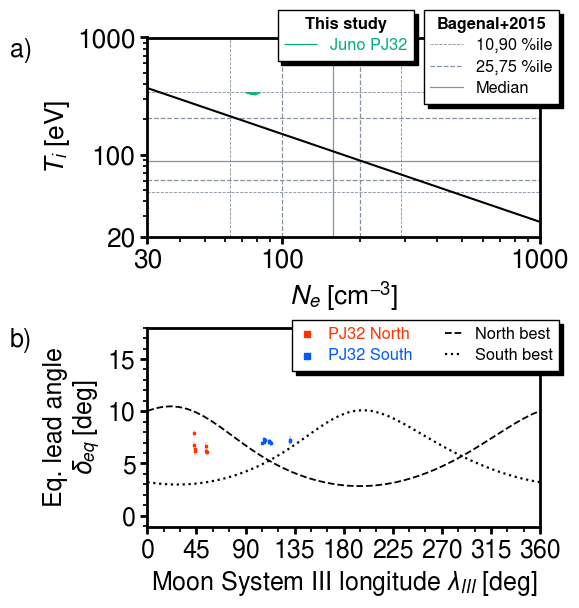

In [77]:
# Galieo fit - Bagenal+2015
Ne_fit = np.linspace(30, 1000, 20)
Ti_fit = 370*((30/Ne_fit)**0.75)

# Northern hemisphere
PJnum = 'PJ32'
data_pd = pd.read_csv('data/Hue23_EFP_north2.txt', skiprows=2,
                        names=['PJ', 'UTC_TIME',
                                'Moon_SIII_LON',
                                'FP_LON',
                                'FP_LAT',
                                'FP_LON_ERR',
                                'FP_LAT_ERR',
                                'EMISSION_ANGLE',
                                'EQ_LEAD_ANGLE',
                                'EQ_LEAD_ANGLE_ERR'],
                        sep=',')
PJdataN = data_pd[data_pd['PJ'].str.contains(PJnum)]

# Southern hemisphere
data_pd = pd.read_csv('data/Hue23_EFP_south2.txt', skiprows=2,
                        names=['PJ', 'UTC_TIME',
                                'Moon_SIII_LON',
                                'FP_LON',
                                'FP_LAT',
                                'FP_LON_ERR',
                                'FP_LAT_ERR',
                                'EMISSION_ANGLE',
                                'EQ_LEAD_ANGLE',
                                'EQ_LEAD_ANGLE_ERR'],
                        sep=',')
PJdataS = data_pd[data_pd['PJ'].str.contains(PJnum)]

# Plot
fontsize = 19
fig, ax = plt.subplots(2,1, figsize=(6.2,6), dpi=100)
panelname = ['a','b','c','d','e','f','g','h']
for i in range(ax.size):
    ax[i].tick_params(axis='x', labelsize=fsize)
    ax[i].tick_params(axis='y', labelsize=fsize)
    ax[i].text(-0.35, 1.0, panelname[i]+')', color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[i].transAxes,
           fontsize=fsize)

# ==========
# FIRST PLOT
# ==========
ax[0].tick_params(axis='both', which='both', labelsize=fontsize)
ax[0].set_xlabel('$N_e$ [cm$^{-3}$]', fontsize=fontsize)
ax[0].set_ylabel('$T_i$ [eV]', fontsize=fontsize)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlim(30,1000)
ax[0].set_ylim(20,1000)
ax[0].set_xticks(np.array([30,100,1000], dtype=int))
ax[0].set_xticklabels(np.array([30,100,1000], dtype=int))
ax[0].set_yticks(np.array([20,100,1000], dtype=int))
ax[0].set_yticklabels(np.array([20,100,1000], dtype=int))

yr = ['14', '22']
redblue = [cud4[0], cud4[3]]

chi2 = np.loadtxt('img/LeadangleFit/PJ32/params_chi2.txt')
RHO0 = np.loadtxt('img/LeadangleFit/PJ32/params_RHO0.txt')
Ti0 = np.loadtxt('img/LeadangleFit/PJ32/params_Ti0.txt')

# chi square 0 is not true value.
chi2min = np.min(chi2[np.where(chi2>0)])
chi2min_pos = np.where(chi2==chi2min)
chi2max = np.max(chi2[np.where(chi2>0)])
chi2ave = np.average(chi2[np.where(chi2>0)])
chi2[np.where(chi2==0)] = np.nan
print(chi2min_pos, 'rho_min', RHO0[chi2min_pos], 'Ti_min', Ti0[chi2min_pos])

# ax.scatter(chi2min_pos[1], chi2min_pos[0], marker='*', color=redblue[i], zorder=3)
cn = ax[0].contour((RHO0/Ai)*Zi, Ti0, chi2,
                levels=[chi2min+2.30, chi2min+6.17, chi2min+11.8],
                colors=cud4[2],
                linewidths=0.9,
                zorder=2)
# cn.levels = [r'$1\sigma$', r'$2\sigma$', r'$3\sigma$']
# cl = ax[0].clabel(cn, cn.levels, inline=True, fontsize=fontsize*0.45)
# Line stroke around clabels
# plt.setp(cl, path_effects=[pe.withStroke(linewidth=2., foreground='white')])
# Line stroke around contour
# plt.setp(cn.collections, path_effects=[pe.withStroke(linewidth=3, foreground="w")])



ax[0].plot(Ne_fit, Ti_fit, color='k', zorder=1.5)
ax[0].axhline(y=340, color=cud4bs[7], linewidth=0.6, label='10,90 %ile', linestyle='dashed', zorder=0.9)  # H/C
ax[0].axvline(x=63, color=cud4bs[7], linewidth=0.6, linestyle='dashed', zorder=0.9)   # H/C
ax[0].axhline(y=205, color=cud4bs[7], linewidth=0.9, label='25,75 %ile', linestyle='dashed', zorder=0.9)    # 75
ax[0].axvline(x=100, color=cud4bs[7], linewidth=0.9, linestyle='dashed', zorder=0.9)    # 25
ax[0].axhline(y=88, color=cud4bs[7], linewidth=0.9, label='Median', zorder=0.9)  # Medium
ax[0].axvline(x=158, color=cud4bs[7], linewidth=0.9, zorder=0.9)                        # Medium
ax[0].axhline(y=61, color=cud4bs[7], linewidth=0.9, linestyle='dashed', zorder=0.9)     # 25
ax[0].axvline(x=200, color=cud4bs[7], linewidth=0.9, linestyle='dashed', zorder=0.9)    # 75
ax[0].axhline(y=48, color=cud4bs[7], linewidth=0.6, linestyle='dashed', zorder=0.9)   # L/H
ax[0].axvline(x=290, color=cud4bs[7], linewidth=0.6, linestyle='dashed', zorder=0.9)  # L/H


# ===========
# SECOND PLOT
# ===========
ax[1].set_xlabel("Moon System III longitude $\\lambda_{III}$ [deg]", fontsize=fsize)
ax[1].set_xlim(0, 360)
ax[1].set_xticks(np.arange(0, 361, 45))
ax[1].set_xticklabels(np.arange(0, 361, 45), fontsize=fsize)
ax[1].xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
ax[1].set_ylim(-1.05, 18)
ax[1].set_ylabel('Eq. lead angle\n$\delta_{eq}$ [deg]', fontsize=fsize)
ax[1].set_yticks(np.arange(0, 18, 5))
ax[1].set_yticklabels(np.arange(0, 18, 5))
ax[1].yaxis.set_minor_locator(AutoMinorLocator(5))  # minor ticks

# PJ26-North
ax[1].scatter(PJdataN['Moon_SIII_LON'], PJdataN['EQ_LEAD_ANGLE'], marker=',', s=0.95, c=cud4[0],
                label='PJ32 North', zorder=1)
ax[1].errorbar(PJdataN['Moon_SIII_LON'], PJdataN['EQ_LEAD_ANGLE'], yerr=PJdataN['EQ_LEAD_ANGLE_ERR'],
                linestyle='none', c=cud4[0], elinewidth=0.3, marker='none', zorder=1.5)

# PJ26-South
ax[1].scatter(PJdataS['Moon_SIII_LON'], PJdataS['EQ_LEAD_ANGLE'], marker=',', s=0.95, c=cud4[3],
                label='PJ32 South', zorder=1)
ax[1].errorbar(PJdataS['Moon_SIII_LON'], PJdataS['EQ_LEAD_ANGLE'], yerr=PJdataS['EQ_LEAD_ANGLE_ERR'],
                linestyle='none', c=cud4[3], elinewidth=0.3, marker='none', zorder=1.5)

# PJ26-North
data = np.loadtxt('bestfitPJ32_N.txt')
ax[1].plot(np.degrees(data[0,:]), data[1,:],
           linestyle='dashed', linewidth=1.3, color='k',
           label='North best')

# PJ26-South
data = np.loadtxt('bestfitPJ32_S.txt')
ax[1].plot(np.degrees(data[0,:]), data[1,:],
           linestyle='dotted', linewidth=1.6, color='k',
           label='South best')

fig.tight_layout()


# =====================
# LEGEND FOR FIRST PLOT
# =====================
legend1 = ax[0].legend(loc='upper right',
                    bbox_to_anchor=(1.07, 1.18),
                    fancybox=False,
                    facecolor='white',
                    framealpha=1,
                    edgecolor='k',
                    fontsize=fontsize*0.62,
                    labelspacing=0.34,)
legend1.set_title('Bagenal+2015', prop={'size': fontsize*0.62, 'weight': 'bold'})
legend_shadow(fig, ax[0], legend1, dx=0.006, dy=-0.0075)

h1,_ = cn.legend_elements()
legend2 = ax[0].legend([h1[0]],['Juno PJ32'],
                    markerscale=5,
                    loc='upper right',
                    bbox_to_anchor=(0.7, 1.18),
                    fancybox=False,
                    facecolor='white',
                    framealpha=1,
                    edgecolor='k',
                    fontsize=fontsize*0.62,
                    labelspacing=0.34,)
legend2.set_title('This study', prop={'size': fontsize*0.62, 'weight': 'bold'})
legend_shadow(fig, ax[0], legend2, dx=0.006, dy=-0.0075)

# get contour colors
i = 0
for leg2text in legend2.get_texts():
    leg2text.set_color(cud4[2])
    i += 1

ax[0].add_artist(legend1)

# ======================
# LEGEND FOR SECOND PLOT
# ======================
legend3 = ax[1].legend(loc='upper right',
                    ncol=2,
                    markerscale=5,
                    bbox_to_anchor=(1.07, 1.08),
                    fancybox=False,
                    facecolor='white',
                    framealpha=1,
                    edgecolor='k',
                    fontsize=fontsize*0.62,
                    labelspacing=0.34,
                    handlelength=1,)
# legend1.set_title('Bagenal+2015', prop={'size': fontsize*0.62, 'weight': 'bold'})
legend_shadow(fig, ax[1], legend3, dx=0.006, dy=-0.0075)

# get plot colors
i = 0
txtcolor = [cud4[0], cud4[3], 'k', 'k']
for legtext in legend3.get_texts():
    legtext.set_color(txtcolor[i])
    i += 1

plt.plot()